<a href="https://colab.research.google.com/github/ion-bueno/bert-from-inside/blob/main/Inside_a_NLP_multitasking_neural_network_BERT%2C_one_model_to_rule_them_all.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installation

During this notebook it is used Pytorch. It is installed running next cell.

In [ ]:
#!pip install torch==1.8.1+cu111 torchvision==0.9.1+cu111 torchaudio==0.8.1 -f https://download.pytorch.org/whl/torch_stable.html

Other modules.

In [ ]:
# Pytorch modules
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
# Colab modules
from google.colab import files
# Usual modules used
from pathlib import Path
import pandas as pd
import numpy as np
import math
import random
import os
import json
import shutil
import matplotlib.pyplot as plt
import seaborn as sns

Mount drive to load files from Google Drive. Useful to load trained models.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1 - Background

Recurrent neural networks (RNN) were declared as state of the art in sequence modeling and transduction problems, in particular long short-term memory (LSTM) and gated recurrent neural networks (GRU).

These models work respect the position of the symbols, input and output. They generate a sequence of hidden states $h_t$, function of previous hidden states $h_{t-1}$ and current input $x_t$.

\begin{equation}
  h_t = f(x_t, h_{t-1})
\end{equation}


![RNN](https://raw.githubusercontent.com/ion-bueno/bert-from-inside/main/images/RNN.png)

> RNN high level structure. Original image from [Dive into Deep Learning](https://d2l.ai/)

However, RNNs are really slow to train due to the sequential computation they employ. This operations cannot be optimized with modern hardware employed today (GPUs or TPUs).

Another important issue is the difficulty to capture long-term dependencies. Gradient based learning algorithms face many problems as the sequence or spans increases. Gradients can exploit or vanish, resulting in many difficulties for gradient optimization.

One novel mechanism employed was **Attention**. It is based on retaining the most significant information. It is applied between the elements of the input and the output. In translation for example, between the source sentence and the translation. Attention has been widely used for many tasks, specially in translation.

In this work we are interested in one type of attention: **Self-attention**. Attention is only applied between the elements of the input sequence, relating themselves.

# 2 - Self Attention

It is an attention mechanism relating different positions of a single sequence in order to compute a representation of the sequence. The goal is mapping sets to sets, regardless of the order in the sequence. Self-attention has been used successfully in a variety of tasks including reading comprehension, abstractive summarization, textual entailment and learning task-independent sentence representations. \\

## 2.1 - Word Embeddings

If we have a sentence with length $ n $, each word is usually represented with a word vector $ x_i \in \mathbb R^{d}, i \in \lbrace1, \dots, n \rbrace $, where $ d $ is the dimension of the vector. This parameter depends on the size of embedding we are using. 

\begin{array}
  \text{The} & \text{orange} & \text{is} & \text{very} & \text{healthy} \\
  x_1 & x_2 & x_3 & x_4 & x_5
\end{array}


In [ ]:
#@title { vertical-output: true }
sentence = "The orange is very healthy" #@param {type:"string"}
list_sentence = sentence.split()
#@markdown Dimension of the embedding vector
d =  3#@param {type:"number"}
vocab = set(list_sentence)
word_to_ix = {word: i for i, word in enumerate(vocab)}
embeds = nn.Embedding(len(word_to_ix), d)

for word in list_sentence:
  lookup_tensor = torch.tensor(word_to_ix[word], dtype=torch.long)
  vector = embeds(lookup_tensor)
  print(word)
  print(vector.detach().numpy(), '\n')

The
[-0.31746945 -0.7561296  -1.6417314 ] 

orange
[ 1.0567445  1.3392346 -1.5657164] 

is
[ 0.38440773  1.9201869  -1.7528055 ] 

very
[-0.6748045   0.6028945  -0.38523147] 

healthy
[0.22498168 2.5262623  0.47089648] 



These vectors do not provide context information, i.e. the relationship with the rest of the elements in the sequence. For example, $ x_2 $ does not determine if *orange* refers to the color or to the fruit, so it is not clear if it exists a clear relationship with *healthy*.

We are looking for an output vector, formed by attention weigths, $ y_i \in \mathbb R^{n}, i \in \lbrace1,\dots,n\rbrace $, where $ n $ is the number of elements in the sequence. For all $ i, j \in \lbrace{1,\dots,n}\rbrace $.

\begin{equation}
  y_i = \sum^{n}_{j} x_j w_{ij}
\end{equation}

The question is, how could we get these weigths? In order to illustrate the process, we are going to use the previous sentence and get the weights associated to the new embedding vector for *orange* ($ y_{2} $).

> Remember that $ n $ is the number of words in the sentence and $ d $ the dimension of the word vectors.

> The explanation is based in the slides of [A series of videos on transformers](https://www.youtube.com/playlist?list=PLDw5cZwIToCvXLVY2bSqt7F2gu8y-Rqje) by Lennart Svensson

## 2.2 - Weighted Averages of Words

The traditional idea was based in providing larger weigths to similar words making use of the **dot product**. Two similar vectors are going to get a bigget dot product than two very distant. Applying the dot product and softmax respect $ x_2 $

\begin{equation}
  \begin{matrix} z_{1} = x_1^T x_2 & \dots & z_{n} = x_n^T x_2 \end{matrix} \\
  \begin{bmatrix} w_{1} & \dots & w_{n} \end{bmatrix} = \text{softmax} \begin{pmatrix} z_{1} & \dots & z_{n} \end{pmatrix} \\
  y_2 = \sum_{j=1}^{n} x_j w_{j}
\end{equation}

![Weighted Averaged of Words](https://raw.githubusercontent.com/ion-bueno/bert-from-inside/main/images/weight_ave_words.png)

> Observations and weights respect time. Original image from [A series of videos on transformers](https://www.youtube.com/playlist?list=PLDw5cZwIToCvXLVY2bSqt7F2gu8y-Rqje)

Intuitively, it is a method which could obatin good results. Nevertheless, several times correlated words are not necessary close. Therefore it is not an accurate and general method to extract the information between one element and the rest of the sequence.

## 2.3 - Weights in Self-Attention

We need to introduce three new vectors: **query**, **keys** and **values**. It is also included three new parameters: $ W_Q, W_K, W_V $, which are going to be trained. For all $ i \in \lbrace{1,\dots,n}\rbrace $.

\begin{matrix}
  \text{Query} & \rightarrow & q_i = W^Q x_2 \\
  \text{Keys} & \rightarrow & k_i = W^K x_i \\
  \text{Values} & \rightarrow & v_i = W^V x_i 
\end{matrix}

Instead of using directly the inputs $ x_i $, it is employed the **query** $ q_i $ and **keys** $ k_i $ to calculate the weights:
\begin{equation}
    \begin{matrix} z_{1} = \frac{k_1^T q_2}{\sqrt{d}} & \dots & z_{n} = \frac{k_n^T q_2}{\sqrt{d}} \end{matrix} \\
  \begin{bmatrix} w_1 & \dots & w_n \end{bmatrix} = \text{softmax} \begin{pmatrix} z_1 & \dots & z_n \end{pmatrix}
\end{equation}


To calculate the final embedding vector it is used the **values** $ v_i $ instead of the inputs $ x_i $

\begin{equation}
  y_2 = \sum_{j=1}^{n} v_j w_{j}
\end{equation}

Intuitively,the query attends the word for which we are going to get the attention weights. Keys corresponds with the rest of the elements in the dot product operation. Values are used in the final combination with the weights. Thanks to learnable matrixes, these combinations are optimized to find combinations and correlations in the own sentence.

![Self-attention process](https://raw.githubusercontent.com/ion-bueno/bert-from-inside/main/images/self-attention_process.png)

> Self-attention process. Original image from [Illustrated: Self-Attention](https://towardsdatascience.com/illustrated-self-attention-2d627e33b20a)

### 2.3.1 - Matrix Notation

To represent the whole process in matrix notation:

\begin{matrix}
  \text{Input} & \rightarrow & X = \begin{bmatrix} x_1 & \dots & x_n \end{bmatrix}
\end{matrix}

In [ ]:
lookup_tensor = torch.tensor([word_to_ix[word] for word in list_sentence], dtype=torch.long)
X = embeds(lookup_tensor).T
print('Input: word per column\n')
print(X.detach().numpy())

Input: word per column

[[-0.31746945  1.0567445   0.38440773 -0.6748045   0.22498168]
 [-0.7561296   1.3392346   1.9201869   0.6028945   2.5262623 ]
 [-1.6417314  -1.5657164  -1.7528055  -0.38523147  0.47089648]]


Calculate **query**, **keys** and **values**:

\begin{matrix}
  Q = W^Q X = \begin{bmatrix} q_1 & \dots & q_n \end{bmatrix}  \\
  K = W^K X = \begin{bmatrix} k_1 & \dots & k_n \end{bmatrix} \\
  V = W^V X = \begin{bmatrix} v_1 & \dots & v_n \end{bmatrix}
\end{matrix}

In [ ]:
# initialize weight matrixes
dim = (X.shape[-1], X.shape[0])
W_Q = torch.randn(dim)
W_K = torch.randn(dim)
W_V = torch.randn(dim)

# calculate query, keys, values
Q = W_Q @ X
K = W_K @ X
V = W_V @ X

print('Query\n')
print(Q.detach().numpy(), '\n')
print('Keys\n')
print(K.detach().numpy(), '\n')
print('Values\n')
print(V.detach().numpy(), '\n')

Query

[[ 0.40143386  1.4549783   1.3745883   0.00988346  0.4754185 ]
 [-2.2835617  -2.7096138  -2.2824137   0.1534014   1.1689688 ]
 [-2.3086407  -0.7271125  -0.8702544  -0.35365814  1.8533789 ]
 [ 0.28501964 -0.25374693  0.37790537  0.6649422   0.3226221 ]
 [-0.03956471 -1.0332265   0.7107655   1.7592607   1.5696275 ]] 

Keys

[[-3.6956363  -6.423422   -7.0837703  -1.2404075  -1.286077  ]
 [-0.87281394  2.9651587   4.331558    1.4782315   4.811989  ]
 [ 0.10588197 -1.2205676  -1.4331455  -0.2650718  -1.2491778 ]
 [ 2.6784935   1.2734275   0.75933963 -0.27580094 -2.7265365 ]
 [-0.59819865  0.5450333   0.17361934 -0.40630165  0.5639424 ]] 

Values

[[ 1.5186684e+00  1.2753845e+00  1.9212992e+00  8.3878815e-01
   5.3446352e-02]
 [-1.1084964e+00  6.7837077e-01 -6.3989872e-01 -1.4200007e+00
  -1.5725984e-03]
 [-7.0784152e-01  3.3553225e-01  1.3670356e+00  1.0299271e+00
   2.3493910e+00]
 [-2.2009237e+00  1.1667681e+00  1.9532933e+00  6.9959748e-01
   4.2658615e+00]
 [ 2.1095672e+00 -7.623

Calculate the **weights**:

\begin{matrix}
  Z = \frac{K^T Q}{\sqrt{d}} \\
  W = \text{softmax}(Z)
\end{matrix}

In [ ]:
Z = (K.T @ Q) / (d)
# dim=0 since we want to apply it per column
W = nn.LogSoftmax(dim=0)(Z)
print('Weigths\n')
print(W.detach().numpy(), '\n')

Weigths

[[-0.32573107 -0.44227198 -0.3947039  -1.8314507  -2.5964112 ]
 [-2.7399578  -5.1851063  -4.0858665  -1.1288322  -1.9056249 ]
 [-3.7487602  -6.5165844  -5.5190873  -1.3678294  -1.8587875 ]
 [-1.7845215  -1.1012802  -1.2774891  -2.2016933  -1.7377019 ]
 [-3.8165622  -4.0228477  -3.6281216  -1.889592   -0.8098069 ]] 



Finally, we get the **output** matrix:

\begin{matrix}
  \text{Output} & \rightarrow & Y = VW = \begin{bmatrix} y_1 & \dots & y_n \end{bmatrix}
\end{matrix}

In [ ]:
Y = V @ W
print('Output\n')
print(Y.detach().numpy(), '\n')

Output

[[-12.892485  -20.943724  -17.679747   -8.796818  -11.445624 ]
 [  3.441215    2.7129316   3.0171936   5.2690396   5.2436395]
 [-16.61799   -20.920595  -18.475939   -7.6592283  -5.0348387]
 [-27.331787  -35.736576  -31.049734   -9.559011   -4.8098927]
 [  5.7925434   8.169694    6.673355   -2.1323311  -4.6081295]] 



As it is normal, we have not obtained a meaningful result, since $ W^Q, W^K, W^V $ have not been trained. At the end, we are looking for a rectangular matrix which relates every word in the sentence. 

![Intuition self-attention](https://raw.githubusercontent.com/ion-bueno/bert-from-inside/main/images/intuition_att.png)

> Intuition about attention. Image from [exBERT](https://huggingface.co/exbert/?model=bert-base-cased&modelKind=bidirectional&sentence=The%20orange%20is%20very%20healthy&layer=0&heads=..0,1,2,3,4,5,6,7,8,9,10,11&threshold=0.7&tokenInd=null&tokenSide=null&maskInds=..&hideClsSep=true) tool

# 3 - The Transformer

In 2017 was presented the Transformer in the paper [Attention is All You Need](https://arxiv.org/abs/1706.03762). It is the first transduction model relying entirely on self-attention to compute representations of its input and output without using sequence aligned RNNs or convolution. The Transformer reached a new state of the art in translation quality, the original goal for the model. 

![Transformer architecture](https://raw.githubusercontent.com/ion-bueno/bert-from-inside/main/images/transformer.png)

> Transformer architecture. Image from [Attention is All You Need](https://arxiv.org/abs/1706.03762)

In order to understand how the Transformer works, it is going to be explained the main parts.

> The code is based mainly in the implementation of [The Annotated Transformer](http://nlp.seas.harvard.edu/2018/04/03/attention.html), which implements the model step by step as it is discussed in the original paper.

## 3.1 - Model Architecture

The model is based in an encoder-decoder structure, as other competitive neural sequence transduction models. It receives as input a complete sentence and generates the probabilities for the next word as output. Usually it is selected the higher one and feed it into the decoder until it is selected the token which indicates the end of sequence. 

![High level transformer architecture](https://raw.githubusercontent.com/ion-bueno/bert-from-inside/main/images/hl_trans_archi.png)

> High-level transformer architecture. From the slides of [A series of videos on transformers](https://www.youtube.com/watch?v=0SmNEp4zTpc&list=PLDw5cZwIToCvXLVY2bSqt7F2gu8y-Rqje)


The Transformer generates a one symbol at a time, consuming the previously generated symbols as additional input, so it is an example of auto-regressive model.

## 3.2 - Input Embedding

Before going into the encoder and decoder stacks, mention how the sentences are preprocessed. The word vectors used as input in the encoder and the decoder are formed by the sum of other two vectors: **word embedding** and **positional encoding**.

> Let's define some variables:



*   Number of sentences in a batch: $ m $
*   Number of words per sentence: $ n $
*   Embedding dimension: $ d_{model} $
*   Size of vocabulary: $ vocab $




![Transformer input embedding](https://raw.githubusercontent.com/ion-bueno/bert-from-inside/main/images/in_emb.png)

> Transformer input embedding

### 3.2.1 - Word Embeddings

It is used learned embeddings to convert the input tokens and output tokens to vectors of dimension $ d_{model} $. It is shared the same weight matrix between the two embbeding layers, similar to [Using the Output Embedding to Improve Language Models](https://arxiv.org/abs/1608.05859). Also mention those weihts are multiplied by $ \sqrt{d_{model}} $.

In [ ]:
class Embeddings(nn.Module):
  def __init__(self, d_model, vocab):
    super(Embeddings, self).__init__()
    self.lut = nn.Embedding(vocab, d_model)
    self.d_model = d_model

  def forward(self, x):
    return self.lut(x) * math.sqrt(self.d_model)

### 3.2.2 - Positional Encoding

The attention blocks only map sets to sets, due to that, there is not any information about the position of the word in the sentence. Then it is injected some information about the relative or absolute position. In the original paper, it is used sine and cosine functions of different frequencies:

\begin{equation}
  PE_{(pos, 2i)} = sin(pos/10000^{2i/d_{model}}) \\
  PE_{(pos, 2i+1)} = cos(pos/10000^{2i/d_{model}})
\end{equation}

In [ ]:
class PositionalEncoding(nn.Module):
  """Implement the PE function

  """
  def __init__(self, d_model, dropout, max_len=5000):
    super(PositionalEncoding, self).__init__()
    self.dropout = nn.Dropout(p=dropout)
    pe = torch.zeros(max_len, d_model)
    position = torch.arange(0, max_len).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2) * 
                         -(math.log(10000.0) / d_model))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    pe = pe.unsqueeze(0)
    self.register_buffer('pe', pe)


  def forward(self, x):
    x = x + Variable(self.pe[:, :x.size(1)], requires_grad=False)
    return self.dropout(x)

The output is the addition of both embeddings. 

\begin{matrix}
  x_i = & \underbrace{E_i}_\text{Word Embedding} & + & \underbrace{P_i}_\text{Positional Encoding}
\end{matrix}

Let's see how is the input and how is transformed after this process

Function to mask Transformer inputs

In [ ]:
def subsequent_mask(size):
  """Mask out subsequent positions

  """
  attn_shape = (1, size, size)
  subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
  return torch.from_numpy(subsequent_mask) == 0

Class to manage one batch of data

In [ ]:
class Batch:
  """Object for holding a batch of data with mask during training

  """
  def __init__(self, src, trg=None, pad=0):
    self.src = src
    self.src_mask = (src != pad).unsqueeze(-2)
    if trg is not None:
      self.trg = trg[:, :-1]
      self.trg_y = trg[:, 1:]
      self.trg_mask = self.make_std_mask(self.trg, pad)
      self.ntokens = (self.trg_y != pad).data.sum()

  @staticmethod
  def make_std_mask(tgt, pad):
    """Create a mask to hide padding and future words

    """
    tgt_mask = (tgt != pad).unsqueeze(-2)
    tgt_mask = tgt_mask & Variable(subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
    return tgt_mask

Function to generate a random batch of data

In [ ]:
def batch_gen(V, batch, words):
  """Generate random data for a src-tgt copy task.

  Args:
  V (int): until number created for random int
  batch (int): number of rows
  words (int): number of columns

  Returns:
  Batch

  """
  data = torch.from_numpy(np.random.randint(1, V, size=(batch, words)))
  data[:, 0] = 1
  src = Variable(data, requires_grad=False)
  tgt = Variable(data, requires_grad=False)
  return Batch(src, tgt, 0)

We can check the Transformer input

In [ ]:
#@title { vertical-output: true }
#@markdown Number of sentences in a batch
m = 5 #@param {type:"integer"}

#@markdown Number of words in a sentence
n = 10 #@param {type:"integer"}

#@markdown Embedding dimension
d_model = 512 #@param {type:"integer"}

#@markdown Vocabulary size
vocab = 11 #@param {type:"integer"}

batch = batch_gen(vocab, m, n)
emb = Embeddings(d_model, vocab)
pos = PositionalEncoding(d_model, 0.01)

emb_w = emb.lut.weight
print('Embedding matrix with dimension: (vocab x d_model)')
print(tuple(emb_w.shape), '\n')
#print(emb_w.detach().numpy(), '\n')

enc_in = batch.src
print('Encoder input before embedding with dimension: (m x n) ')
print(tuple(enc_in.shape), '\n')

enc_out = nn.Sequential(emb, pos)(enc_in)
print('Encoder input with dimension: (m x n x d_model)')
print(tuple(enc_out.shape), '\n')

dec_in = batch.trg
print('Decoder input before embedding  with dimension: (m x n-1) ')
print(tuple(dec_in.shape), '\n')

dec_out = nn.Sequential(emb, pos)(dec_in)
print('Decoder input with dimension: (m x n-1 x d_model)')
print(tuple(dec_out.shape), '\n')

Embedding matrix with dimension: (vocab x d_model)
(11, 512) 

Encoder input before embedding with dimension: (m x n) 
(5, 10) 

Encoder input with dimension: (m x n x d_model)
(5, 10, 512) 

Decoder input before embedding  with dimension: (m x n-1) 
(5, 9) 

Decoder input with dimension: (m x n-1 x d_model)
(5, 9, 512) 



## 3.3 - Encoder

The encoder stacks $ N $ encoder blocks which map sets to sets, what means the output size is the same than input: $ ( m \ x \ n \ x \ d_{model} ) $. In the original implementation, they employ $ N=6 $ encoders.

![Transformer's encoder](https://raw.githubusercontent.com/ion-bueno/bert-from-inside/main/images/encoder.png)

> Encoder architecture. Modified image from [Attention is All You Need](https://arxiv.org/abs/1706.03762)

Each block is formed by two sub-layers: **Multi-Head Attention** and **Feed Forward**. Both are followed by an **Add \& Norm** layer.

### 3.3.1 - Multi-Head Attention

The Transformer differs for using exclusively self-attention. This model employs a type of self-attention called **Scaled Dot-Product Attention**

#### 3.3.1.1 - Scaled Dot-Product Attention

It is fast and space-efficient in practice, since it can be implemented using highly optimized matrix multiplication code.

We have queries $ Q $ and keys $ K $ of dimension $ d_k $ and values $ V $ of dimension $ d_v $.

\begin{equation}
  \text{Attention}(Q, K, V) = \text{softmax}(\frac{QK^T}{\sqrt{d_k}})V
\end{equation}

For large values of $ d_k $ the softmax function could have extremely small gradients. For this reason, the dot product is scaled by $ \frac{1}{\sqrt{d_k}} $.

![Scaled dot product attention](https://raw.githubusercontent.com/ion-bueno/bert-from-inside/main/images/sdp_attention.png)

In [ ]:
def sdp_attention(query, key, value, mask=None, dropout=None):
  d_k = query.size(-1)
  scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
  if mask is not None:
    scores = scores.masked_fill(mask == 0, -1e9)
  p_attn = F.softmax(scores, dim=-1)
  if dropout is not None:
    p_attn = dropout(p_attn)
  return torch.matmul(p_attn, value), p_attn

> To remember variables:

*   Number of sentences in a batch: $ m $
*   Number of words per sentence: $ n $
*   Embedding dimension: $ d_{model} $

> And let's introduce new ones


*   Attention blocks: $ h $
*   Dimension attention layers: $ d_k = \frac{d_{model}}{h} $

Multi-Head Attention is based on performing attention in parallel. There are $ h $ different blocks, with identical structure but different parameterers: $ W^Q $, $ W^K $ and $ W^V $. The output vectors from different heads are concatenated for each word using the parameter $ W^O $.

\begin{equation}
  \text{MultiHead}(Q,K,V) = \text{Concat}(\text{head}_1, \dots, \text{head}_h) W_O \\
  \text{where} \ \text{head}_i = \text{Attention}(QW^Q_i, KW^K_i, VW^V_i) \\
  W^Q_i \in \mathbb R^{d_{model}\ x \ d_k}, \ W^K_i \in \mathbb R^{d_{model}\ x \ d_k}, \ W^V_i \in \mathbb R^{d_{model}\ x \ d_v} \\
  W^O \in \mathbb R^{h d_v\ x \ d_{model}}
\end{equation}

The idea is to get information from different representation subspaces at different positions. To get an intuition, we could see it as one head is understanding the sentence gramatically, another one from the point of spelling, etc.

> In the papers [Attention is All You Need](https://arxiv.org/abs/1706.03762) and [The Annotated Transformer](http://nlp.seas.harvard.edu/2018/04/03/attention.html), it is used $ h = 8 $ and they assume that $ d_v = d_k $.

![Multi-Head Attention](https://raw.githubusercontent.com/ion-bueno/bert-from-inside/main/images/multi__head_attention.png)

To generate $ N $ identical layers:

In [ ]:
import copy

def clones(module, N):
  return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

A class to represent Multi-Head Attention:

In [ ]:
class MultiHeadAttention(nn.Module):
  
  def __init__(self, h, d_model, dropout=0.1):
    super(MultiHeadAttention, self).__init__()
    assert d_model % h == 0
    # To assume d_v always equals d_k
    self.d_k = d_model // h
    self.h = h
    self.linears = clones(nn.Linear(d_model, d_model), 4)
    self.attn = None
    self.dropout = nn.Dropout(p=dropout)


  def forward(self, query, key, value, mask=None):
    if mask is not None:
      # Same mask applied to all h heads.
      mask = mask.unsqueeze(1)
    nbatches = query.size(0)

    # 1) Do all the linear projections in batch from d_model => h x d_k
    query, key, value = \
      [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
      for l, x in zip(self.linears, (query, key, value))]

    # 2) Apply attention on all the projected vectors in batch.
    att_out, self.attn = sdp_attention(query, key, value, mask=mask, 
                                       dropout=self.dropout)

    # 3) "Concat" using a view and apply a final linear.
    concat_out = att_out.transpose(1, 2).contiguous().view(nbatches, -1, 
                                                           self.h * self.d_k)

    # 4) Last linear
    return query, key, value, att_out, concat_out, self.linears[-1](concat_out)

We can see how the tensor is divided into the $ h $ heads and then contactenated to recover its original shape.

In [ ]:
#@title  { vertical-output: true }
#@markdown Attention blocks
h =  8#@param {type:"integer"}

# get previous output as input
input = enc_out

multi = MultiHeadAttention(h , d_model)
q, k, v, att, concat, output = multi(input, input, input)

print('Input with dimension: (m x n)')
print(tuple(input.shape), '\n')

print('Query, keys and values with dimension: (m x h x n x d_k)')
print(tuple(q.shape), '\n')

print('Output with dimension: (m x n x d_model)')
print(tuple(output.shape), '\n')

for w, layer in zip(['W_Q', 'W_K', 'W_V', 'W_O'], multi.linears): 
  print(f'{w} with dimension: {tuple(layer.weight.shape)}')

Input with dimension: (m x n)
(5, 10, 512) 

Query, keys and values with dimension: (m x h x n x d_k)
(5, 8, 10, 64) 

Output with dimension: (m x n x d_model)
(5, 10, 512) 

W_Q with dimension: (512, 512)
W_K with dimension: (512, 512)
W_V with dimension: (512, 512)
W_O with dimension: (512, 512)


### 3.3.2 - Feed-Forward

Each layer contains a fully connected feed-forward network. It is used different parameters between blocks.

\begin{equation}
  \text{FFN}(x) = \text{max}(0,\ xW_1 \ + \ b_1)W_2 \ + \ b_2
\end{equation}

> In the original paper the input and output have dimensionality $ d_{model} = 512 $ and the inner-layer $ d_{ff} = 2048 $.

In [ ]:
class PositionwiseFeedForward(nn.Module):

  def __init__(self, d_model, d_ff, dropout=0.1):
    super(PositionwiseFeedForward, self).__init__()
    self.w_1 = nn.Linear(d_model, d_ff)
    self.w_2 = nn.Linear(d_ff, d_model)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    return self.w_2(self.dropout(F.relu(self.w_1(x))))

### 3.3.3 Add & Norm

This layer corresponds to a [residual connection](https://openaccess.thecvf.com/content_cvpr_2016/html/He_Deep_Residual_Learning_CVPR_2016_paper.html) followed by [layer normalization](https://arxiv.org/abs/1607.06450) in both sub-layers. The goal of a residual connection is easing the training, with layers learning functions with reference to the layer inputs, instead of learning unreferenced ones. The layer normalization is a normalization which is applied per feature.

![Layer Normalization](https://raw.githubusercontent.com/ion-bueno/bert-from-inside/main/images/layer_norm.png)

> Layer Normalization

Then, the output of each sub-layer is:

\begin{equation}
    \text{LayerNorm}(x \ + \ \text{Sublayer}(x))
\end{equation}

where $ \text{Sublayer}(x) $ is the function implemented by the corresponding sub-layer. 

In order to reduce overfitting, it is applied dropout to the output of each sub-layer, before it is added to the sub-layer input and normalized.

In [ ]:
class LayerNorm(nn.Module):

  def __init__(self, features, eps=1e-6):
    super(LayerNorm, self).__init__()
    self.a_2 = nn.Parameter(torch.ones(features))
    self.b_2 = nn.Parameter(torch.zeros(features))
    self.eps = eps

  def forward(self, x):
    mean = x.mean(-1, keepdim=True)
    std = x.std(-1, keepdim=True)
    return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

To show normalization process in a layer

In [ ]:
#@title { vertical-output: true }
#@markdown This variable would correspond with d_model in the Transformer
features = 5 #@param {type:"integer"}
rows = 2 #@param {type:"integer"}

batch_norm = batch_gen(5, rows, features)
input = batch_norm.src.float()
print('Input')
print(input.detach().numpy(), '\n')

output = LayerNorm(features)(input)
print('Output')
print(output.detach().numpy())

Input
[[1. 3. 4. 1. 1.]
 [1. 3. 1. 1. 3.]] 

Output
[[-0.7071063  0.7071063  1.4142126 -0.7071063 -0.7071063]
 [-0.730296   1.0954442 -0.730296  -0.730296   1.0954442]]


Class to represent Sublayer Connection

In [ ]:
class SublayerConnection(nn.Module):
  """A residual connection followed by a layer norm.
  Note for code simplicity the norm is first as opposed to last
  
  """
  def __init__(self, size, dropout):
    super(SublayerConnection, self).__init__()
    self.norm = LayerNorm(size)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x, sublayer):
    """Apply residual connection to any sublayer with the same size

    """
    return x + self.dropout(sublayer(self.norm(x)))



---



Now that all layers are explained, we can implement the whole encoder. First, it is defined the class for an instance in the stack.

In [ ]:
class EncoderLayer(nn.Module):

  def __init__(self, size, self_attn, feed_forward, dropout):
    super(EncoderLayer, self).__init__()
    self.self_attn = self_attn
    self.feed_forward = feed_forward
    self.sublayer = clones(SublayerConnection(size, dropout), 2)
    self.size = size

  def forward(self, x, mask):
    x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
    return self.sublayer[1](x, self.feed_forward)

And the whole class for the encoder

> In the original paper they used a stack of $ N=6 $

In [ ]:
class Encoder(nn.Module):
    
  def __init__(self, layer, N):
    super(Encoder, self).__init__()
    self.layers = clones(layer, N)
    self.norm = LayerNorm(layer.size)

  def forward(self, x, mask):
    for layer in self.layers: 
      x = layer(x, mask)
    return self.norm(x)

To show encoder

In [ ]:
#@title 
#@markdown Attention blocks
h =  8#@param {type:"integer"}
#@markdown Embedding dimension
d_model = 512 #@param {type:"integer"}
#@markdown Dimension inner layer
d_ff = 2048 #@param {type:"integer"}
#@markdown Dropout
dropout = 0.1 #@param {type:"number"}
#@markdown Encoder blocks
N = 6 #@param {type:"integer"}

c = copy.deepcopy
attn = MultiHeadAttention(h, d_model)
ff = PositionwiseFeedForward(d_model, d_ff, dropout)

enc_block = EncoderLayer(d_model, c(attn), c(ff), dropout)
encoder = Encoder(enc_block, N)

print(f'One encoder block, there are {N} like this\n')
print(encoder.layers[0])

One encoder block, there are 6 like this

EncoderLayer(
  (self_attn): MultiHeadAttention(
    (linears): ModuleList(
      (0): Linear(in_features=512, out_features=512, bias=True)
      (1): Linear(in_features=512, out_features=512, bias=True)
      (2): Linear(in_features=512, out_features=512, bias=True)
      (3): Linear(in_features=512, out_features=512, bias=True)
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (feed_forward): PositionwiseFeedForward(
    (w_1): Linear(in_features=512, out_features=2048, bias=True)
    (w_2): Linear(in_features=2048, out_features=512, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (sublayer): ModuleList(
    (0): SublayerConnection(
      (norm): LayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): SublayerConnection(
      (norm): LayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
)


## 3.4 - Decoder

It is also composed of a stack of $ N $ decoder blocks. Using the output from the encoder its function is also mapping sets to sets, maintaning the shape: number of vectors $ m $ and length $ n $. However, the dimensionality in the number of words differs one position from the encoder, being the size: $ ( m \ x \ n-1 \ x \ d_{model} ) $. In the original implementation, they employ $ N=6 $ decoders.

![Transformer's decoder](https://raw.githubusercontent.com/ion-bueno/bert-from-inside/main/images/decoder.png)

> Decoder architecture. Modified image from [Attention is All You Need](https://arxiv.org/abs/1706.03762)

The architecture is almost equal to the encoder. Appart from the dimension, there are other two differences:

-   The mask for the first multi-attention.
-   The encoder's output used as input in the second multi-attention.



### 3.4.1 - Masked Multi-Head Attention

The use of a mask is already implemented in the self-attention function and in the generation of a batch. This prevents attending to subsequent positions and ensures that the predictions only depend on known outputs previous to the current one.

![Masked self-attention](https://raw.githubusercontent.com/ion-bueno/bert-from-inside/main/images/masked_attn.png)

> Self-attention intuition in encoder and decoder. Image from [Transformer video](https://www.youtube.com/watch?v=TQQlZhbC5ps&list=PLTl9hO2Oobd_bzXUpzKMKA3liq2kj6LfE) by CodeEmporium.

In [ ]:
enc_mask = batch.src_mask.detach().numpy()
dec_mask = batch.trg_mask[0].detach().numpy()

print('No mask used in encoder\n')
print(enc_mask, '\n\n')

print('Mask used in decoder\n')
print(dec_mask)

No mask used in encoder

[[[ True  True  True  True  True  True  True  True  True  True]]

 [[ True  True  True  True  True  True  True  True  True  True]]

 [[ True  True  True  True  True  True  True  True  True  True]]

 [[ True  True  True  True  True  True  True  True  True  True]]

 [[ True  True  True  True  True  True  True  True  True  True]]] 


Mask used in decoder

[[ True False False False False False False False False]
 [ True  True False False False False False False False]
 [ True  True  True False False False False False False]
 [ True  True  True  True False False False False False]
 [ True  True  True  True  True False False False False]
 [ True  True  True  True  True  True False False False]
 [ True  True  True  True  True  True  True False False]
 [ True  True  True  True  True  True  True  True False]
 [ True  True  True  True  True  True  True  True  True]]


### 3.4.2 - Encoder-Decoder Self-Attention

The second sublayer in the decoder is a multi-head attention, without mask in this case, but using the encoder's output as input in the block.

\begin{matrix}
  \text{Query} & \rightarrow & Q^D  & \text{from decoder's input embedding} \\
  \text{Keys} & \rightarrow & K^E & \text{from encoder's output} \\
  \text{Values} & \rightarrow & V^E & \text{from encoder's output}
\end{matrix}

Once these two differences are explained, it can be implemented the decoder's blocks.

In [ ]:
class DecoderLayer(nn.Module):

  def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
    super(DecoderLayer, self).__init__()
    self.size = size
    self.self_attn = self_attn
    self.src_attn = src_attn
    self.feed_forward = feed_forward
    self.sublayer = clones(SublayerConnection(size, dropout), 3)

  def forward(self, x, memory, src_mask, tgt_mask):
    
    x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
    x = self.sublayer[1](x, lambda x: self.src_attn(x, memory, memory, src_mask))
    return self.sublayer[2](x, self.feed_forward)

And the complete decoder.

In [ ]:
class Decoder(nn.Module):

  def __init__(self, layer, N):
    super(Decoder, self).__init__()
    self.layers = clones(layer, N)
    self.norm = LayerNorm(layer.size)

  def forward(self, x, memory, src_mask, tgt_mask):
    for layer in self.layers:
      x = layer(x, memory, src_mask, tgt_mask)
    return self.norm(x)

To show decoder architecture.

In [ ]:
#@title 
#@markdown Attention blocks
h =  8#@param {type:"integer"}
#@markdown Embedding dimension
d_model = 512 #@param {type:"integer"}
#@markdown Dimension inner layer
d_ff = 2048 #@param {type:"integer"}
#@markdown Dropout
dropout = 0.1 #@param {type:"number"}
#@markdown Encoder blocks
N = 6 #@param {type:"integer"}

c = copy.deepcopy
attn = MultiHeadAttention(h, d_model)
ff = PositionwiseFeedForward(d_model, d_ff, dropout)

dec_block = DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout)
decoder = Decoder(dec_block, N)

print(f'One decoder block, there are {N} like this\n')
print(decoder.layers[0])

One decoder block, there are 6 like this

DecoderLayer(
  (self_attn): MultiHeadAttention(
    (linears): ModuleList(
      (0): Linear(in_features=512, out_features=512, bias=True)
      (1): Linear(in_features=512, out_features=512, bias=True)
      (2): Linear(in_features=512, out_features=512, bias=True)
      (3): Linear(in_features=512, out_features=512, bias=True)
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (src_attn): MultiHeadAttention(
    (linears): ModuleList(
      (0): Linear(in_features=512, out_features=512, bias=True)
      (1): Linear(in_features=512, out_features=512, bias=True)
      (2): Linear(in_features=512, out_features=512, bias=True)
      (3): Linear(in_features=512, out_features=512, bias=True)
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (feed_forward): PositionwiseFeedForward(
    (w_1): Linear(in_features=512, out_features=2048, bias=True)
    (w_2): Linear(in_features=2048, out_features=512, bias=True)
    (dropout): Dropout(p=0

## 3.5 - Generator

The final block is a combination of a feed-forward network and a softmax in order to get probabilities for next word.

![Transformer's generator](https://raw.githubusercontent.com/ion-bueno/bert-from-inside/main/images/generator.png)

> Final module, generator. Modified image from [Attention is All You Need](https://arxiv.org/abs/1706.03762)

In [ ]:
class Generator(nn.Module):
   
  def __init__(self, d_model, vocab):
    super(Generator, self).__init__()
    self.proj = nn.Linear(d_model, vocab)

  def forward(self, x):
    return F.log_softmax(self.proj(x), dim=-1)

## 3.6 - Final Visualization


Finally, we can implement the whole transformer architecture.

In [ ]:
class EncoderDecoder(nn.Module):

  def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
    super(EncoderDecoder, self).__init__()
    self.encoder = encoder
    self.decoder = decoder
    self.src_embed = src_embed
    self.tgt_embed = tgt_embed
    self.generator = generator

  def forward(self, src, tgt, src_mask, tgt_mask):
    return self.decode(self.encode(src, src_mask), src_mask, tgt, tgt_mask)

  def encode(self, src, src_mask):
    return self.encoder(self.src_embed(src), src_mask)

  def decode(self, memory, src_mask, tgt, tgt_mask):
    return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

Function to get a transforme by just setting the parameters.

In [ ]:
def make_model(src_vocab, tgt_vocab, N=6, d_model=512, d_ff=2048, h=8, dropout=0.1):
    c = copy.deepcopy
    attn = MultiHeadAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
            Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
            Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), N),
            nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
            nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
            Generator(d_model, tgt_vocab))

    # This was important from their code.
    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)

    return model

Set the Transformer parameters.

In [ ]:
#@markdown Size of source vocabulary
src_vocab = 11#@param {type:"integer"}
#@markdown Size of target vocabulary
tgt_vocab = 11#@param {type:"integer"}
#@markdown Number of encoder and decoder blocks
N = 6#@param {type:"integer"}
#@markdown Inner Transformer size
d_model = 512#@param {type:"integer"}
#@markdown Hidden feed forward size
d_ff = 2048#@param {type:"integer"}
#@markdown Number of attention heads
h = 8#@param {type:"integer"}
#@markdown Dropout probability
dropout = 0.1#@param {type:"number"}

model = make_model(src_vocab, tgt_vocab, N, d_model, d_ff, h, dropout)

To visualize the whole architecture or per block.

In [ ]:
#@markdown Select a block in the Transformer to visualize it
block = "transformer" #@param ["transformer", "encoder", "decoder", "src_embed", "tgt_embed", "generator"]

if block == 'transformer':
    print(model)
else:
    print(getattr(model, block))

EncoderDecoder(
  (encoder): Encoder(
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn): MultiHeadAttention(
          (linears): ModuleList(
            (0): Linear(in_features=512, out_features=512, bias=True)
            (1): Linear(in_features=512, out_features=512, bias=True)
            (2): Linear(in_features=512, out_features=512, bias=True)
            (3): Linear(in_features=512, out_features=512, bias=True)
          )
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (feed_forward): PositionwiseFeedForward(
          (w_1): Linear(in_features=512, out_features=2048, bias=True)
          (w_2): Linear(in_features=2048, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (sublayer): ModuleList(
          (0): SublayerConnection(
            (norm): LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): SublayerConnection(
            (norm): LayerNorm()
 

# 4 - BERT

**B**idirectional **E**ncoder **R**epresentations from **T**ransformer, released in 2019 in paper [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/abs/1810.04805), obtaining new state-of-the-art results on eleven NLP tasks. 

BERT was designed to pretrain deep bidirecional representations from unlabeled text by using self-attention to get the left and right context. This pretrained model can be fine-tuned adding one output layer and used for a wide range of NLP tasks.

> The original model developed in TensorFlow is in [github.com/google-research/bert](https://github.com/google-research/bert), but it is going to be used the libray of [HuggingFace](https://huggingface.co/transformers/index.html) to show the model

In [ ]:
!pip install transformers

     |████████████████████████████████| 2.3MB 6.8MB/s 
     |████████████████████████████████| 901kB 38.9MB/s 
     |████████████████████████████████| 3.3MB 57.4MB/s 


## 4.1 - Model Architecture

It is a multi-layer bidirectional Transformer encoder, based on [Attention is All You Need](https://arxiv.org/abs/1706.03762) and implemented as [The Annotated Transformer](http://nlp.seas.harvard.edu/2018/04/03/attention.html). The different hyperparameters and the original notation are:



*   Number of layers: $ L $, number of encoder blocks which compose the whole stack. Previously defined as $ N $ in the Encoder part.

*   Hidden size: $ H $, embedding dimension of the model. Previously deined as $ d_{model} $.

*   Self-attention heads: $ A $, number of heads in self-attention blocks. Previously defined as $ h $.


There are defined two model sizes: 

\begin{matrix}
  \text{BERT}_{\text{BASE}} & \rightarrow & L=12, \ H=768, \ A=12 & \text{Total parameters}:\ 110\text{M} \\
  \text{BERT}_{\text{LARGE}} & \rightarrow & L=24, \ H=1024, \ A=16 & \text{Total parameters}:\ 340\text{M}
\end{matrix}

In both cases the inner layer for the last feed-forward block is defined as $ 4H $, being in the BASE 3072 and in the LARGE 4096.

BERT has been already trained, so we can easily instantiate one of the base model classes of the [HuggingFace](https://huggingface.co/transformers/index.html) library from a pretrained model. To load the required model is used the class [`BertModel`](https://huggingface.co/transformers/model_doc/bert.html#transformers.BertModel).

> [HuggingFace](https://huggingface.co/transformers/index.html) has the the possibility to differentiate between *cased* and *uncased* models. 

In [ ]:
from transformers import BertModel

In [ ]:
#@markdown Select one configuration
model_name = "bert-base-uncased" #@param ["bert-base-uncased", "bert-base-cased", "bert-large-uncased", "bert-large-cased"]
# We need to create the model and tokenizer
model = BertModel.from_pretrained(model_name)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


The warning is telling us we are throwing away some weights and randomly initializing some other. That is because we are removing the head used to pretrain the model on a masked language modeling objective and replacing it with a new head for which we don't have pretrained weights, so the library warns us we should fine-tune this model before using it for inference, which is exactly what we are going to do in next sections.

In [ ]:
#@markdown Select whole model or a block to visualize it
block = "bert" #@param ["bert", "embeddings", "encoder", "pooler"]
if block == 'bert':
    print(model)
else:
    print(getattr(model, block))

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

### 4.1.1 - Input-Output Representations

In order to handle a variety of tasks, the input can be a single sentence or a pair of sentences in one token sequence, which is certainly the name given to the input. The input representation of a word is the addition of three different embeddings:

*   **Token Embedding**: normal word embedding. It is used WordPiece with a 30.000 token vocabulary.

*   **Segment Embedding**: to differentiate the sentence the word belongs to. It is used the special token $ [SEP] $ to separate both sentences. 

*   **Position Embedding**: to indicate the position in the whole sequence.

The first token is always a special classification token $ [CLS] $, whose final hidden state layer is used in classification tasks.



![BERT's input](https://raw.githubusercontent.com/ion-bueno/bert-from-inside/main/images/in_BERT.png)

> Input Embedding. Image from [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/abs/1810.04805)

In [ ]:
print(model.embeddings)

BertEmbeddings(
  (word_embeddings): Embedding(30522, 768, padding_idx=0)
  (position_embeddings): Embedding(512, 768)
  (token_type_embeddings): Embedding(2, 768)
  (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (dropout): Dropout(p=0.1, inplace=False)
)


As output we get the corresponding sequence embedding, as it is explained in the encoder, and *NSP* for classification. These values are going to be explained better in *Pre-Training* section.

## 4.2 - Pre-training

This step is in charge of the model to understand the language and its context. It is used two unsupervised tasks instead of the traditional left-to-right or right-to-left.

![Pre-training BERT](https://raw.githubusercontent.com/ion-bueno/bert-from-inside/main/images/pretrain_BERT.png)

> Pre-training process in BERT. Image from [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/abs/1810.04805)

### 4.2.1 - Masked Language Model (MLM)

Some tokens are masked at random and then predicted. The final $ T_i $ vectors have the sime size and are generated simultaneously. They are fed into an output softmax over the vocabulary (30k) to get a distribution and compare with cross entropy loss in order to train the model.

However, as the output have all the worlds, included the ones were not masked, it is only considered the ones were masked and ignores the others to calculate the cross entropy loss. This ensures more focus into predict the masked values and increases the context awareness.

![MLM](https://raw.githubusercontent.com/ion-bueno/bert-from-inside/main/images/cross_entro_BERT.png)

> Prediction of masked word in BERT.

### 4.2.2 - Next Sentence Prediction (NSP)

Many important tasks as question and answering are based on understanding relationship between two sentences, which is not captured by language modeling. For that reason, while the model is being trained in MLM, is also trained in next sentence prediction.

For this purpose it is used the special token $ [CLS] $ in the input and $ C $ in the output to indicate if *Sentence B* could follow *Sentence A*.

![Pre-train BERT](https://raw.githubusercontent.com/ion-bueno/bert-from-inside/main/images/pretrain_BERT_methods.png)

> MLM and NSP in pre-training BERT.

### 4.2.3 - Self-Attention Visualization

As it has been mentioned, the model contains $ L $ blocks and $ A $ attention heads. Many models which come from BERT acquired the encoder to perform self-attention. Self-attention operations are not straightforward, even further if we have different blocks and many heads into them.

To get an intuition for BERT (and other similar models) respect the attention weights between the elements, we can use [exBERT](https://huggingface.co/exbert/?model=bert-base-cased&modelKind=bidirectional&sentence=This%20model%20has%20revolutionized%20the%20world!&layer=0&heads=..0,1,2,3,4,5,6,7,8,9,10,11&threshold=0.7&tokenInd=null&tokenSide=null&maskInds=..&hideClsSep=true). Following next steps:

1. First we select a model and introduce the input sentence.
2. We can choose if hide special tokens and the percentage of attention shown.
3. We select an encoder block (as *Layer*).
4. Lastly the attention heads we want to visualize.

![exBERT](https://raw.githubusercontent.com/ion-bueno/bert-from-inside/main/images/exbert.png)

> Example of [exBERT](https://huggingface.co/exbert/?model=bert-base-cased&modelKind=bidirectional&sentence=This%20model%20has%20revolutionized%20the%20world!&layer=0&heads=..0,1,2,3,4,5,6,7,8,9,10,11&threshold=0.7&tokenInd=null&tokenSide=null&maskInds=..&hideClsSep=true) visualization.

## 4.3 - Fine-Tuning

Thanks to self-attention, which is in charge of applying bidirectional cross attention between the two sentences, is straightforward to model many downstream tasks. In addition to, the two sentences as input in pretraining are equivalent to different trainings in NLP as sentence pairs in paraphrasing, hypothesis-premise pairs, question-passage pairs, etc.


![Fine-tune BERT](https://raw.githubusercontent.com/ion-bueno/bert-from-inside/main/images/finetune_examples.png)

> Different NLP tasks implemented by fine-tuning BERT.

The output token representations are fed into an output layer and the $ C $ is fed into an output layer for classification. Only new parameters are learned from sratch, while the rest are slightly fine-tuned. 

That is the reason fine-tune is relatively inexpensive in computation cost compared with pretraining. In the original paper, authors claim that all of the results can be replicated in at most 1 hour on a single Cloud TPU, or a few hours on a GPU, starting from the exact same pre-trained model.

![Fine-tune BERT details](https://raw.githubusercontent.com/ion-bueno/bert-from-inside/main/images/finetune_BERT_details.png)

> Output layer added in fine-tuning.

# 5 - Sentiment Analysis



A tradiditonal task in NLP is **Sentiment Analysis**. The target is to determine if the sentence has a *positive* or *negative* sentiment, corresponding with a binary classification problem. As it is normal, these two labels depend on the context of our text. In spite of being one of the most simple applications, it is really useful and currently demanded in many applications, for example in films or series reviews.

In addition to be a standard assignment, it compounds one of the task of [GLUE](https://gluebenchmark.com/) (General Language Understanding Evaluation), a group of nine classification tasks on sentences or pairs of sentences, which is commonly used to evaluate state-of-the-art models. Sentiment analysis corresponds with [SST-2](https://nlp.stanford.edu/sentiment/index.html) (Stanford Sentiment Treebank).

![Sentiment Analysis](https://raw.githubusercontent.com/ion-bueno/bert-from-inside/main/images/sentiment_analysis.PNG)

> Example of sentiment analysis in one of the [Hugging Face's models](https://huggingface.co/models).

> For this task, two tutorials [Fine tuning BERT for Sentiment Analysis](https://skimai.com/fine-tuning-bert-for-sentiment-analysis/) and [BERT Fine-Tuning Tutorial with PyTorch](http://mccormickml.com/2019/07/22/BERT-fine-tuning/), have been used as guide and support to the development of the application.

## 5.1 - Setup

In spite of being much faster than pre-training, fine-tune a BERT model for any class could be slow for a CPU. Due to that, we are going to try using a GPU.

> In case of running it from Colab, we could make use of Google's GPUs. Make sure to select GPU from *Runtime > Change runtime type > Hardware accelerator > GPU*.

In [ ]:
# If there's a GPU available...
if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")


There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [ ]:
def info_device():
    # If there's a GPU available
    if torch.cuda.is_available():
        print(f'\nUsing GPU {torch.cuda.get_device_name(0)}.', '\n')
    # If not
    else:
        print('\nNo GPU available, using the CPU instead.', '\n')

## 5.2 - Load SST-2 Dataset

First of all we need to download the dataset. We’ll use the `wget` package to download the dataset to the Colab instance’s file system.

In [ ]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-cp37-none-any.whl size=9681 sha256=d1fc06afaf733f98395f4a136a04865c519b7ab9b30f654ccb3969c3e623db78
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In this [repository](https://github.com/nyu-mll/GLUE-baselines) is explained how to manage GLUE datasets, altough in this case we only need the corresponding URL. We donwload the dataset and then unzip it to access it.

In [ ]:
import wget

sentiment_dir = Path('sentiment_analysis')
if not os.path.exists(sentiment_dir):
    !mkdir $sentiment_dir

# The URL for the dataset zip file.
url = 'https://dl.fbaipublicfiles.com/glue/data/SST-2.zip'

# Download the file (if we haven't already)
if not os.path.exists('./SST-2.zip'):
    print('Downloading dataset...')
    wget.download(url, './SST-2.zip')

# Unzip the dataset (if we haven't already)
sst2_dataset = Path('sst-2_dataset')
if not os.path.exists(sst2_dataset):
    !unzip SST-2.zip
    shutil.move('SST-2', sst2_dataset)

Archive:  SST-2.zip
   creating: SST-2/
  inflating: SST-2/dev.tsv           
   creating: SST-2/original/
  inflating: SST-2/original/README.txt  
  inflating: SST-2/original/SOStr.txt  
  inflating: SST-2/original/STree.txt  
  inflating: SST-2/original/datasetSentences.txt  
  inflating: SST-2/original/datasetSplit.txt  
  inflating: SST-2/original/dictionary.txt  
  inflating: SST-2/original/original_rt_snippets.txt  
  inflating: SST-2/original/sentiment_labels.txt  
  inflating: SST-2/test.tsv          
  inflating: SST-2/train.tsv         


There are three different datasets: *train.csv*, *test.csv*, *dev.csv*. As its own name indicates, they are used for training, testing and validate respectively, the studied model. As there is a [GLUE leaderboard](https://gluebenchmark.com/leaderboard), the test dataset is not labeled. In order to study the performance of our model, we are going to divide the train dataset, which has enough samples, into train and test. Test set is going to be one third of the original train test.

In [ ]:
from sklearn.model_selection import train_test_split

train_df = pd.read_csv(sst2_dataset/'train.tsv', delimiter='\t', header=1, names=['sentence', 'label'])
val_df = pd.read_csv(sst2_dataset/'dev.tsv', delimiter='\t', header=1, names=['sentence', 'label'])
train_df, test_df = train_test_split(train_df, test_size=0.33, shuffle=True)

They are saved into a dictionay to allow an easy access.

In [ ]:
# Load the datasets into a pandas dataframe.
original_datasets = {
    'train':    train_df, 
    'val':      val_df, 
    'test':     test_df
}

To get a fast intuition on the dataset, we can plot some used sentences for the three splits. Mention the label 1 corresponds with positive sentiment while label 0 with negative.

\begin{matrix}
    \text{Class 0} & \rightarrow & \text{Negative sentiment} \\
    \text{Class 1} & \rightarrow & \text{Positive sentiment}
\end{matrix}

In [ ]:
#@markdown Select a split
split = "train" #@param ["train", "val", "test"]

#@markdown Select number of examples to visualize it
num_examples = 5 #@param {type:"slider", min:1, max:10, step:1}

print(f'Some sentences of {split} split, which has a length of {len(original_datasets[split])}\n')
pd.set_option("max_colwidth", 150)
original_datasets[split].sample(num_examples)

Some sentences of train split, which has a length of 45123



,sentence,label
36265,possibly the best actor,1
29016,just lapses into unhidden british,0
32615,has the right stuff for silly summer entertainment,1
40913,what a reckless squandering of four fine acting talents,0
59603,"sly , sophisticated and surprising",1


Depending on the computation velocity, training process could be more or less slow. For a fast intuition on the model, we can remove some data, since the original size of the dataset has more than 60k samples only in training. With `perc` we select the percentage of data we are going to use. Removed sample are selected randomly.

In [ ]:
#@title 5.2.1 Resize dataset { vertical-output: true }
#@markdown Percentage of dataset to use %
perc = 100 #@param {type:"slider", min:1, max:100, step:1}
datasets = {}

for key, df in original_datasets.items():
    new_df = df.sample(n=round(len(df)*(perc/100)), random_state=np.random.RandomState())
    datasets[key] = new_df.reset_index(drop=True)
    if perc != 100:
        print(f'{key:<10}', f'From: {len(original_datasets[key]):<10}', f'To: {len(datasets[key]):<10}')
    else:
        print(f'{key:<10}', f'size: {len(original_datasets[key]):<10}')

train      size: 45123     
val        size: 871       
test       size: 22225     


It is important to know how many samples we have per class in our training dataset, in case we are dealing with an imbalanced classification problem. The number of samples is going to depend on how the original train datatset has been splitted to get the test set.

In [ ]:
train_labels = datasets['train'].label

# Print resulted samples
print(f"{'Total samples':^15} | {'Positive':^10} | {'Negative':^10}")
print(42*'-')
print(f"{len(train_labels):^15} | {len(train_labels[train_labels==1]):^10} | {len(train_labels[train_labels==0]):^10}")
print(42*'-')

 Total samples  |  Positive  |  Negative 
------------------------------------------
     45123      |   25248    |   19875   
------------------------------------------


## 5.3 -  Preprocessing data

Before input sequences into BERT, it is necessary to preprocess data. Depending on the model, there are more or less steps to do, but mainly the guide to follow is:

*   Tokenize sequences. Convert text into integers according to embedding space used. There are many literature about tokenization algorithms.

*   Pad each sentence to the maximum length there is in your batch.

*   Truncate each sentence to the maximum length the model can accept (if applicable). 


![Tokenization](https://raw.githubusercontent.com/ion-bueno/bert-from-inside/main/images/tokenization.png)

Remember that BERT input follows next scheme

\begin{matrix}
    \text{[CLS]} & \text{Sentence A} & \text{[SEP]} & \text{Sentence B} & \text{[SEP]}
\end{matrix}

or

\begin{matrix}
    \text{[CLS]} & \text{Sentence} & \text{[SEP]}
\end{matrix} \\

depending on the final task. Our case, classification of one sentence, corresponds with second option.


In order to preprocess according to the model, it is going to be used the [`BertTokenizer`](https://huggingface.co/transformers/model_doc/bert.html?highlight=berttokenizer#transformers.BertTokenizer) from Hugging Face which ensures that we get a tokenizer that corresponds to the model architecture we want to use. Besides that, it downloads the vocabulary used when pretraining this specific checkpoint.


It is necessary to pass to the tokenizer the name of the pre-trained model we are going to use. For this task the selected one is [`bert-base-uncased`](https://huggingface.co/bert-base-uncased), a base BERT which does not distinguish between upper and lower case.

In [ ]:
from transformers import BertTokenizer

MODEL_NAME = 'bert-base-uncased'

# Load the BERT tokenizer.
print('Loading BERT tokenizer...\n')
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

Loading BERT tokenizer...



From this instance we can get many information about the model: 

- Dimension of the vocabulary used
- Maximum allowed length of the model
- In which size is applied padding
- Special used tokens for separation token, padding token, classification token, mask token and other unknown tokens.


In [ ]:
#@markdown Select an option to visualize it
attribute = "vocab_size" #@param ["vocab_size", "model_max_length", "padding_side", "sep_token", "pad_token", "cls_token", "mask_token", "unk_token"]

print(getattr(tokenizer, attribute))

30522


BERT works with sentences of same dimension. Due to that, it is required to pad (add padding tokens until a specified size) or truncate (separate a sentence if it is longer than the maximum model length). For this reason it is very useful to know which is the maximum length in our sentences, and limit the input size to this value.

In [ ]:
# Concatenate sentences in datasets
all_sentences = np.concatenate([datasets['train'].sentence.values, 
                                datasets['val'].sentence.values, 
                                datasets['test'].sentence.values])

# Encode our concatenated data
encoded_sentences = [tokenizer.encode(sent, add_special_tokens=True) for sent in all_sentences]

# Find the maximum length
max_len = max([len(sent) for sent in encoded_sentences])
print(f'Max length: {max_len}')

Max length: 66


In addition to, we have to add the special tokens: [CLS] at the beginning of a sentence and [SEP] between them, altough in our case it will be only at the end of each one.

In next function, we tokenize each sentence in addition to add special tokens and perform the required padding or truncating operations.

In [ ]:
def preprocessing_for_sa(data, tokenizer, max_len=512):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        encoded_sent = tokenizer.encode_plus(
            sent,                           # Tokenize sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=max_len,             # Max length to truncate/pad
            padding='max_length',           # Pad sentence to max length
            truncation=True,                # Truncate to max_length
            return_attention_mask=True      # Return attention mask
            )
        
        # Get output and attention mask
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

From this function we will get the corresponding token IDs as `input_ids`. Also, the second output `attention_masks`, indicates which tokens are useful and which ones are padding tokens. This requirement in the input is necessary for BERT.

In [ ]:
encoded_datasets = dict.fromkeys(datasets)

for split, df in datasets.items(): 
    encoded_datasets[split] = dict()
    encoded_datasets[split]['input_ids'], encoded_datasets[split]['attention_mask'] = preprocessing_for_sa(df.sentence, tokenizer, max_len)
    # Add the corresponding labels
    encoded_datasets[split]['label'] = torch.tensor(df.label)

To get an intutiton about the whole process, we can print a random sentence as well as the corresponding token IDs and the result after tokenize it.

In [ ]:
# Random index
rnd_index = random.randint(0, len(datasets[split])-1)
# Original sentence
sentence = datasets[split].sentence[rnd_index]
print('Original sentence:')
print(sentence, '\n')

# IDs
ids = encoded_datasets[split]['input_ids'][rnd_index]
print('Token IDs:')
print(ids.detach().numpy(), '\n')

# Token IDs
#tokens = tokenizer.convert_ids_to_tokens(ids)
print('After tokenization:')
print(np.array(tokenizer.convert_ids_to_tokens(ids)))

Original sentence:
charming in comedies like american pie and  

Token IDs:
[  101 11951  1999 22092  2066  2137 11345  1998   102     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0] 

After tokenization:
['[CLS]' 'charming' 'in' 'comedies' 'like' 'american' 'pie' 'and' '[SEP]'
 '[PAD]' '[PAD]' '[PAD]' '[PAD]' '[PAD]' '[PAD]' '[PAD]' '[PAD]' '[PAD]'
 '[PAD]' '[PAD]' '[PAD]' '[PAD]' '[PAD]' '[PAD]' '[PAD]' '[PAD]' '[PAD]'
 '[PAD]' '[PAD]' '[PAD]' '[PAD]' '[PAD]' '[PAD]' '[PAD]' '[PAD]' '[PAD]'
 '[PAD]' '[PAD]' '[PAD]' '[PAD]' '[PAD]' '[PAD]' '[PAD]' '[PAD]' '[PAD]'
 '[PAD]' '[PAD]' '[PAD]' '[PAD]' '[PAD]' '[PAD]' '[PAD]' '[PAD]' '[PAD]'
 '[PAD]' '[PAD]' '[PAD]' '[PAD]' '[PAD]' '[PAD]' '[PAD]' '[P

We will create an iterator for our dataset using the torch [data loader](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) class. This will help save on memory during training and boost the training speed.

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

def generate_data_loaders(batch_size, test=False):
    # Train and val dataloaders
    if test is False:
        dataloaders = list()
        for dataset in (encoded_datasets['train'], 
                        encoded_datasets['val']):
            
            data = TensorDataset(dataset['input_ids'], 
                                dataset['attention_mask'], 
                                dataset['label'])
            sampler = RandomSampler(data)
            dataloader = DataLoader(data, sampler=sampler, batch_size=batch_size)
            dataloaders.append(dataloader)
        return tuple(dataloaders)

    # Test dataloader
    else:
        dataset = encoded_datasets['test']
        data = TensorDataset(dataset['input_ids'], 
                                dataset['attention_mask'], 
                                dataset['label'])
        sampler = SequentialSampler(data)
        return DataLoader(data, sampler=sampler, batch_size=batch_size)

## 5.4 - Create the Model

To fine-tune on GLUE, new parameters introduced are classification layer weigths $ W \in \mathbb R^{K \ x \ H} $, where $ K $ is the number of labels. Then we compute a standard classification loss with $ C $ and $ W $:

\begin{equation}
    \text{log}(\text{softmax}(CW^T))
\end{equation}



![Fine tune sentiment analysis](https://raw.githubusercontent.com/ion-bueno/bert-from-inside/main/images/sentiment_analysis_fine_tune.png)

In **Sentiment Analysis** task, the final model is just a combination of BERT's encoder and a classifier to get the final probabilities.

![BERT Classifier](https://raw.githubusercontent.com/ion-bueno/bert-from-inside/main/images/bert-classifier.png)

> Diagram of BERT Classifier.

Hugging Face provides [`BertForSequenceClassification`](https://huggingface.co/transformers/model_doc/bert.html?highlight=berttokenizer#bertforsequenceclassification) to perform this task. However, in order to show the simplicity of fine-tune process, we are going to create our own model. At the end, this is the combination of the pre-trained [`BertModel`](https://huggingface.co/transformers/model_doc/bert.html#transformers.BertModel) and a classifier, composed by a simple feed-forward neural netword with only one hidden layer, plus a softmax to get the probabilities of each class.

In [ ]:
# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, in_classifier=50, dropout=0.1, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained(MODEL_NAME)

        # Instantiate an one-layer feed-forward classifier
        H = in_classifier
        D_in = self.bert.config.hidden_size

        self.classifier = nn.Sequential(
                nn.Linear(D_in, H),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(H, 2)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        # outputs[0] = last_hidden_state
        # last_hidden_state dimension: (n_batches x words x inner_dim_BERT)
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

Finally, we have to decide the classifier's parameters. In our case the number of neurons in the hidden layer of the neural network as `in_classifier` and a dropout probability as `dropout_classifier`.

In [ ]:
#@markdown Size classifier layer
in_classifier = 50 #@param {type:"integer"}
#@markdown Classifier droput probability
dropout_classifier = 0.01 #@param {type:"number"}
model = BertClassifier(in_classifier, dropout_classifier)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


With the model created, we can visualize each part: the whole model, only pretrained BERT or the classifier.

In [ ]:
#@markdown Select whole model, only pretrained BERT or the classifier
block = "classifier" #@param ["model", "bert", "classifier"]
if block == 'model':
    print(model)
else:
    print(getattr(model, block))

Sequential(
  (0): Linear(in_features=768, out_features=50, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.01, inplace=False)
  (3): Linear(in_features=50, out_features=2, bias=True)
)


To fine-tune our Bert Classifier, we need to create an optimizer. 

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup

def init_model(train_dataloader,
               in_classifier=50, dropout_classifier=0.1, 
               learning_rate=5e-5, epsilon=1e-8, 
               epochs=4):
    # Model
    bert_classifier = BertClassifier(in_classifier, dropout_classifier)
    # Run model in device
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(
        bert_classifier.parameters(),
        lr=learning_rate,    
        eps=epsilon    
    )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

## 5.5 - Fine-Tune on SST-2

Before going into detail about how to fine-tune the model, a recap about binary classification problems. There are 4 possible combinations in a binary classification problem (predict a class between two possible ones).

- **True Positive (TP)**: if both predicted and actual values are *Positive*.
- **False Positive (FP)**: if predicted value is *Positive* and actual one is *Negative*.
- **False Negative (FN)**: if predicted value is *Negative* and actual one is *Positive*.
- **True Negative (NP)**: if both predicted and actual values are *Negative*.



![Confussion matrix](https://raw.githubusercontent.com/ion-bueno/bert-from-inside/main/images/conf_matrix.png)

> Confusion matrix. Predicted vs. real values.

One method to measure the performance of the model is the **accuracy**. This is defined as the coefficient between the number of correct predictions and the total number of predictions. Then, with previous classification possibilities defined we have:

\begin{equation}
    \text{Accuracy} = \frac{\text{Number of correct predictions}}{\text{Total number of predictions}} = \frac{TP \ + \ TN}{TP \ + \ TN \ + \ FP \ + \ FN}
\end{equation}

In addition to the accuracy, we use the [cross-entropy loss](https://machinelearningmastery.com/cross-entropy-for-machine-learning/). Each sample has a known class label with a probability of 1.0, and 0.0 for the other label. The model can estimate the probability of an example belonging to each class label. Cross-entropy can then be used to calculate the difference between the two probability distributions.

In [ ]:
loss_fn = nn.CrossEntropyLoss()

To train the model, as in other architectures, we are going to iterate through batches. At the end of each epoch the model is evaluated respect the validation dataset. We use a [fixed seed](https://machinelearningmastery.com/reproducible-results-neural-networks-keras/) for the random number generator to ensure the same result in two consecutive executions with same parameters, and do not let it to random initialization.

In [ ]:
import datetime
import time

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round(elapsed))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
class BertTrainer():

    def __init__(self, params):
        self.epochs = params['epochs']
        self.train_dataloader, self.val_dataloader = generate_data_loaders(params['batch_size'])
        self.training_stats = []
        self.model, self.optimizer, self.scheduler = init_model(self.train_dataloader,
                                                                params['in_classifier'], params['dropout'],
                                                                params['learning_rate'], params['epsilon'],
                                                                self.epochs)
        
    def set_seed(self, seed_value=42):
        """Set seed for reproducibility.
        """
        random.seed(seed_value)
        np.random.seed(seed_value)
        torch.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)

    def train(self, evaluation=True):
        self.set_seed(42)
        info_device()
        for epoch_i in range(self.epochs):

            # =======================================
            #               Training
            # =======================================
            print(f'======== Epoch {epoch_i+1} / {epochs} ========\n')

            # Print the header of the result table
            print(f'Training: {len(self.train_dataloader)} batches\n')
            print(f"{'Batch':^7} | {'Train Loss':^12} | {'Elapsed':^9}")
            print("-"*35)

            # Measure the elapsed time of each epoch
            training_time = 0
            t0_batch = time.time()

            # Reset tracking variables at the beginning of each epoch
            total_loss, batch_loss, batch_counts = 0, 0, 0

            # Put the model into the training mode
            self.model.train()

            # For each batch of training data...
            for step, batch in enumerate(self.train_dataloader):

                batch_counts +=1
                # Load batch to device
                b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

                # Zero out any previously calculated gradients
                self.model.zero_grad()

                # Perform a forward pass. This will return logits.
                logits = self.model(b_input_ids, b_attn_mask)

                # Compute loss and accumulate the loss values
                loss = loss_fn(logits, b_labels)
                batch_loss += loss.item()
                total_loss += loss.item()

                # Perform a backward pass to calculate gradients
                loss.backward()

                # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)

                # Update parameters and the learning rate
                self.optimizer.step()
                self.scheduler.step()

                # Print the loss values and time elapsed for every 20 batches
                if (step % 20 == 0 and step != 0) or (step == len(self.train_dataloader) - 1):
                    # Calculate time elapsed for 20 batches
                    time_elapsed = time.time() - t0_batch
                    training_time += time_elapsed
                    time_elapsed = format_time(time_elapsed)

                    # Print training results
                    print(f"{step:^7} | {batch_loss / batch_counts:^12.6f} | {time_elapsed:^9}")

                    # Reset batch tracking variables
                    batch_loss, batch_counts = 0, 0
                    t0_batch = time.time()

            # Calculate the average loss over the entire training data
            avg_train_loss = total_loss / len(self.train_dataloader)
            # Format training_time
            training_time = format_time(training_time)

            print("-"*35)
            print(f"{'-':^7} | {avg_train_loss:^12.6f} | {training_time:^9}")
            print("-"*35)
            print("\n")

            # =======================================
            #               Evaluation
            # =======================================

            if evaluation:
                # After the completion of each training epoch, measure the model's performance
                # on our validation set.
                val_loss, val_accuracy, validation_time = self.evaluate()

            print("\n")

            # Record all statistics from this epoch.
            self.training_stats.append(
                {
                    'epoch': epoch_i + 1,
                    'Training Loss': avg_train_loss,
                    'Validation Loss': val_loss,
                    'Accuracy': val_accuracy,
                    'Training Time': training_time,
                    'Validation Time': validation_time
                }
            )

        # Finished all epochs
        print("Training completed!")


    def evaluate(self):
        """After the completion of each training epoch, measure the model's performance
        on our validation set.
        """
        # Put the model into the evaluation mode. The dropout layers are disabled during
        # the test time.
        self.model.eval()

        # Set time
        t0_val = time.time()

        # Tracking variables
        val_accuracy = []
        val_loss = []

        # For each batch in our validation set...
        for batch in self.val_dataloader:
            # Load batch to device
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Compute logits
            with torch.no_grad(): 
                logits = self.model(b_input_ids, b_attn_mask)

            # Compute loss
            loss = loss_fn(logits, b_labels)
            val_loss.append(loss.item())

            # Get the predictions
            preds = torch.argmax(logits, dim=1).flatten()

            # Calculate the accuracy rate
            accuracy = (preds == b_labels).cpu().numpy().mean()
            val_accuracy.append(accuracy)

        # Compute the average accuracy and loss over the validation set.
        val_loss = np.mean(val_loss)
        val_accuracy = np.mean(val_accuracy)

        # Compute elapsed time
        time_elapsed = format_time(time.time() - t0_val)

        print('Evaluation\n')
        print(f"{'Val Loss':^10} | {'Accuracy':^10} | {'Elapsed':^9}")
        print("-"*35)
        print(f"{val_loss:^10.6f} | {val_accuracy:^10.6f} | {time_elapsed:^9}")
        print("-"*35)

        return val_loss, val_accuracy, time_elapsed

Once we have declared the `BertTrainer` class, it is only necessary to specify the parameters to train the model. The authors recommend following hyper-parameters:

- Batch size: 16 or 32
- Learning rate for AdamW optimizer: 5e-5, 3e-5 or 2e-5
- Number of epochs: 2, 3, 4

In [ ]:
#@title 5.5.1 - Hyperparameters Selection
in_classifier = 50 #@param {type:"integer"}
dropout_classifier = 0.1 #@param {type:"number"}
batch_size =  32#@param {type:"integer"}
learning_rate = 5e-5 #@param {type:"number"}
epochs =  3#@param {type:"integer"}
epsilon = 1e-8 #@param {type:"number"}

args = {
    'batch_size': batch_size,
    'in_classifier': in_classifier,
    'dropout': dropout_classifier,
    'learning_rate': learning_rate,
    'epsilon': epsilon,
    'epochs': epochs,
}

And now we only need to train the model.

In [ ]:
trainer = BertTrainer(args)
bert_classifier = trainer.model
trainer.train()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



Using GPU Tesla V100-SXM2-16GB. 

======== Epoch 1 / 3 ========

Training: 1411 batches

 Batch  |  Train Loss  |  Elapsed 
-----------------------------------
  20    |   0.555438   |  0:00:03 
  40    |   0.351080   |  0:00:03 
  60    |   0.339012   |  0:00:03 
  80    |   0.276070   |  0:00:03 
  100   |   0.329376   |  0:00:03 
  120   |   0.315651   |  0:00:03 
  140   |   0.255791   |  0:00:03 
  160   |   0.287897   |  0:00:03 
  180   |   0.259710   |  0:00:03 
  200   |   0.307018   |  0:00:03 
  220   |   0.218056   |  0:00:03 
  240   |   0.309831   |  0:00:03 
  260   |   0.280426   |  0:00:03 
  280   |   0.264489   |  0:00:03 
  300   |   0.235010   |  0:00:03 
  320   |   0.261343   |  0:00:03 
  340   |   0.287082   |  0:00:03 
  360   |   0.239603   |  0:00:03 
  380   |   0.231830   |  0:00:03 
  400   |   0.236977   |  0:00:03 
  420   |   0.257990   |  0:00:03 
  440   |   0.207908   |  0:00:03 
  460   |   0.183973   |  0:00:03 
  480   |   0.234772   |  0:00:03 

After training the model, we can easily print its statistics in a data frame and save it as an excel table.

In [ ]:
# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=trainer.training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# Save data frame
df_stats.to_excel(sentiment_dir/'training_stats.xlsx')

df_stats

,Training Loss,Validation Loss,Accuracy,Training Time,Validation Time
epoch,,,,,
1,0.225543,0.254492,0.919005,0:03:03,0:00:01
2,0.104815,0.241967,0.924107,0:03:03,0:00:01
3,0.055010,0.311103,0.918527,0:03:02,0:00:01


We can print how both (training and validation) losses evolve during epochs.

In [ ]:
def plot_loss_curves(df):
    # Use plot styling from seaborn.
    sns.set(style='darkgrid')

    # Increase the plot size and font size.
    sns.set(font_scale=1.5)
    plt.rcParams["figure.figsize"] = (12,6)

    # Plot the learning curve.
    plt.plot(df['Training Loss'], 'b-o', label="Training")
    plt.plot(df['Validation Loss'], 'g-o', label="Validation")

    # Label the plot.
    plt.title("Training & Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.xticks(df.index.values)

    plt.show()

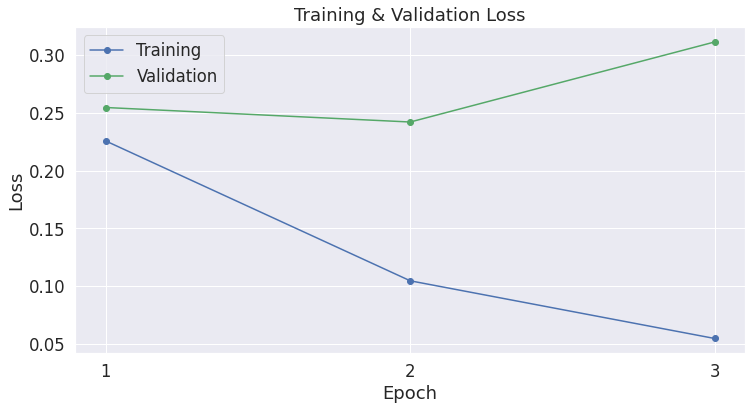

In [ ]:
plot_loss_curves(df_stats)

While the the training loss is going down with each epoch, the validation loss is increasing. This suggests that we are training our model too long, and it is over-fitting on the training data.
			
Validation loss is a more precise measure than accuracy, because with accuracy we do not care about the exact output value, but just which side of a threshold it falls on. If we are predicting the correct answer, but with less confidence, then validation loss will catch this, while accuracy will not.

Last step is to save the fine-tuned model as well as the training arguments.

In [ ]:
def save_json(path, file):
    with open(path, "w") as outfile:
        json.dump(file, outfile)

In [ ]:
print('Saving model...')
torch.save(bert_classifier.state_dict(), sentiment_dir/'pytorch_model.pt')

print('Saving tokenizer data...')
tokenizer.save_pretrained(sentiment_dir)

print('Saving training arguments...')
save_json(sentiment_dir/'training_args.json', args)

print('Saving training statistics..')
save_json(sentiment_dir/'training_stats.json', trainer.training_stats)

And if we want to load it.

In [ ]:
'''path = '/content/drive/MyDrive/Degree/TFG/Models/BertForSentimentAnalysis/pytorch_model.pt'

bert_classifier = BertClassifier()
bert_classifier.load_state_dict(torch.load(path))
bert_classifier.to(device)'''

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tru

## 5.6 - Evaluation

Once our model is fine-tuned, we can evaluate it with the test dataset. We need to define the prediction function which is going to be almost equal to the previous evaluation function, but applying a **softmax** to return the probabilities per class.

In [ ]:
def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Predictions
    all_logits = []

    # Set time
    t0_test = time.time()

    # Tracking variables
    test_accuracy = []
    test_loss = []

    # For each batch in our test set...
    info_device()
    for batch in test_dataloader:
        # Load batch to device
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        test_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean()
        test_accuracy.append(accuracy)
    
    # Compute the average accuracy and loss over the validation set.
    test_loss = np.mean(test_loss)
    test_accuracy = np.mean(test_accuracy)

    # Compute elapsed time
    time_elapsed = format_time(time.time() - t0_test)

    # Calculate probabilities
    all_logits = torch.cat(all_logits, dim=0)
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    test_stats = {
        'Test Loss': test_loss,
        'Accuracy': test_accuracy,
        'Test time': time_elapsed
    }

    print(f"{'Test Loss':^12} | {'Accuracy':^10} | {'Test time':^11}")
    print("-"*40)
    print(f"{test_loss:^12.6f} | {test_accuracy:^10.6f} | {time_elapsed:^11}")
    print("-"*40)
  
    return probs, test_stats

From `BertTrainer` we get the `model` and the `test_dataloader`. Using last function, we get the corresponding probabilities for each class.

In [ ]:
# Compute probabilities in test set
probs, test_stats= bert_predict(bert_classifier, generate_data_loaders(32, test=True))

# Compute predictions
preds = np.argmax(probs, axis=1)

# Test labels
test_df = datasets['test']
y_true = test_df.label


Using GPU Tesla P100-PCIE-16GB. 

 Test Loss   |  Accuracy  |  Test time 
----------------------------------------
  0.068871   |  0.981924  |   0:00:46  
----------------------------------------


In [ ]:
print('Saving test statistics..')
save_json(sentiment_dir/'test_stats.json', test_stats)

Saving test statistics..


To get a fast intuition on the result, we can plot some predicted sentences. Remember that the label 1 corresponds with positive sentiment while label 0 with negative.

In [ ]:
num_examples = 5 #@param {type:"slider", min:1, max:10, step:1}
df = test_df.sample(num_examples)
df['real'] = np.where(df.label==0, 'negative', 'positive')
df['predicted'] = np.where(preds[df.index]==0, 'negative', 'positive')
df['probability'] = np.amax(probs, axis=1)[df.index]
pd.set_option("max_colwidth", 150)
df

,sentence,label,real,predicted,probability
15717,"a look at the `` wild ride '' that ensues when brash young men set out to conquer the online world with laptops , cell phones and sketchy business...",1,positive,positive,0.993305
20709,"it 's rare to find a film to which the adjective ` gentle ' applies , but",1,positive,positive,0.998857
15685,a cutesy romantic tale with a twist .,1,positive,positive,0.999536
20266,"with a tighter editorial process and firmer direction this material could work , especially since the actresses in the lead roles are all more tha...",1,positive,positive,0.530009
1776,"get another phone call warning you that if the video is n't back at blockbuster before midnight , you 're going to face frightening late fees",0,negative,negative,0.998161


### 5.6.1 - Variable Threshold

Sentiment classification task is even difficult for human. Therefore, define a threshold is going to provide a safer margin to classify one class. 

For example, if we define that positive sentiment sample are the only ones where probability of being *positive* is bigger than 0.9, samples classified as positive are going to have surely positive sentiment. The main drawback here is all samples wich are positive and are classified as negative.

To get a better intuiton about the performance, we can plot the confusion matrix.

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, normalize=False):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = "Normalized confusion matrix"
    else:
        title = 'Confusion matrix, without normalization'

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.min() + ((cm.max() - cm.min()) / 2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.grid(False)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

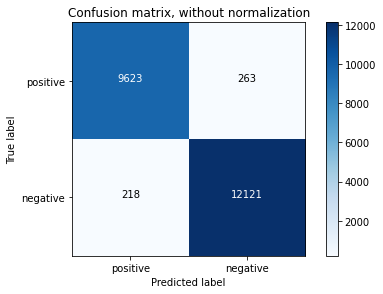

In [ ]:
plot_confusion_matrix(confusion_matrix(preds, y_true), ('positive', 'negative'))

A useful tool to determine an optimal threshold  is the **Receiver Operating Characteristic curve (ROC)**. It is a plot of the false positive rate (x-axis) versus the true positive rate (y-axis) for a number of different candidate threshold values between 0.0 and 1.0.

The **true positive rate** is calculated as the number of true positives divided by the sum of the number of true positives and the number of false negatives. It is also called as **hit rate** and describes how good the model is at predicting the positive class when the actual outcome is positive. It is also known as **sensitivity** or **recall**.

\begin{equation}
    TPR = \frac{TP}{TP \ + \ FN}
\end{equation}

The **false positive rate** is calculated as the number of false positives divided by the sum of the number of false positives and the number of true negatives. It is also called the **false alarm rate** as it summarizes how often a positive class is predicted when the actual outcome is negative.

\begin{equation}
    FPR = \frac{FP}{FP \ + \ TN}
\end{equation}

The complement of the FPR is the **specificity** and it is calculated as:

\begin{equation}
  \text{Specificity} = 1 - FPR
\end{equation}

The Geometric Mean or G-Mean is a metric for imbalanced classification that, if optimized, will seek a balance between the sensitivity and the specificity.

\begin{equation}
    \text{G-Mean} = \sqrt{\text{Sensitivity} \cdot \text{Specificity}}
\end{equation}

One approach to determine the optimized threshold would be to test the model with each threshold and select the one with the largest G-Mean value.

In [ ]:
from sklearn.metrics import roc_curve, auc

def evaluate_roc(probs, y_true):
    fpr, tpr, thresholds = roc_curve(y_true, probs[:, 1])
    roc_auc = auc(fpr, tpr)

    # calculate the g-mean for each threshold
    gmeans = np.sqrt(tpr * (1-fpr))
    # locate the index of the largest g-mean
    ix = np.argmax(gmeans)
    
    # title
    plt.title(f'Receiver Operating Characteristic\nAUC = {roc_auc:.2f}, Best G-Mean = {gmeans[ix]:.2f}')
    # plot ROC curve
    plt.plot([0, 1], [0, 1],'--', label='No skill')
    plt.plot(fpr, tpr, marker='.', label='Bert Classifier')
    plt.plot(fpr[ix], tpr[ix], marker='o', color='black', label=f'Best threshold = {thresholds[ix]:.2f}')
    # show legend
    plt.legend(loc = 'lower right')
    # axis labels
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    # show plot
    plt.show()
    return tpr, fpr, thresholds

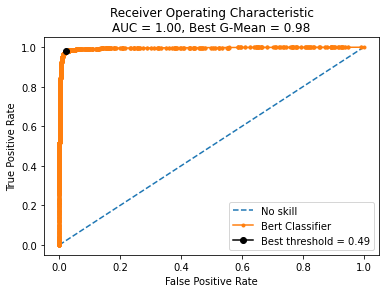

In [ ]:
tpr, fpr, thresholds = evaluate_roc(probs, y_true)

An excellent model has AUC near to the 1 which means it has a good measure of separability. A poor model has AUC near to the 0 which means it has the worst measure of separability. In fact, it means it is reciprocating the result. It is predicting 0s as 1s and 1s as 0s. And when AUC is 0.5, it means the model has no class separation capacity whatsoever.

To confirm the result we can check it with the [Youden's J statistic](https://en.wikipedia.org/wiki/Youden%27s_J_statistic) which is defined as:

\begin{equation}
    \begin{split}
        &J = \text{Sensitivity} + \text{Specificity} - 1 = \\
        &TPR + (1 - FPR) - 1 = TPR - FPR
    \end{split}
\end{equation}

In [ ]:
# get the best threshold
J = tpr - fpr
ix = np.argmax(J)
best_thres = thresholds[ix]
print('Best threshold = %.2f' % (best_thres))

Best threshold = 0.49


Another way to evaluate the skill of a prediction model is with the **Precision-Recall** curve.

Precision is a ratio of the number of true positives divided by the sum of the true positives and false positives. It describes how good a model is at predicting the positive class. Precision is referred to as the positive predictive value.

\begin{equation}
    \text{Precision} = \frac{TP}{TP \ + \ FP}
\end{equation}

As it has been mentioned, **recall** is the same as TPR.

F-Measure or **F1 score** is defined as the harmonic mean of precision (P) and recall (R).

\begin{equation}
    F1 = \frac{2PR}{P \ + \ R}
\end{equation}

As in the ROC curve, the approach to finding the optimal threshold would be to calculate the F-measure for each threshold and select the largest one.

In [ ]:
from sklearn.metrics import precision_recall_curve

def evaluate_prec_recall(probs, preds, y_true):
    precision, recall, thresholds = precision_recall_curve(y_true, probs[:, 1])

    # convert to f score
    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)

    # title
    plt.title(f'Precision-Recall\nBest F1 score = {fscore[ix]:.2f}')
    # plot the precision-recall curves
    no_skill = len(y_true[y_true==1]) / len(y_true)
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No skill')
    plt.plot(recall, precision, marker='.', label='Bert Classifier')
    plt.plot(recall[ix], precision[ix], marker='o', color='black', label=f'Best threshold = {thresholds[ix]:.2f}')
    # show legend
    plt.legend()
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the plot
    plt.show()

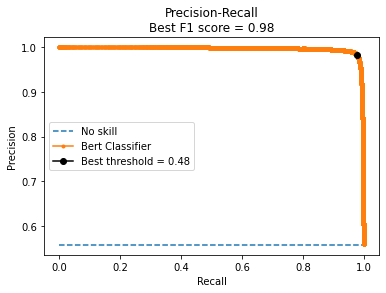

In [ ]:
evaluate_prec_recall(probs, preds, y_true)

A model with perfect skill is depicted as a point at (1,1). A skilful model is represented by a curve that bows towards (1,1) above the flat line of no skill.

ROC curves should be used when there are roughly equal numbers of observations for each class. Precision-Recall curves should be used when there is a moderate to large class imbalance. The reason for this recommendation is that ROC curves present an optimistic picture of the model on datasets with a class imbalance.

Finally, we can predict test samples with the optimized threshold.

In [ ]:
# Get new predictions respect best threshold
preds_thres = np.where(probs[:, 1] > best_thres, 1, 0)

num_examples = 5 #@param {type:"slider", min:1, max:10, step:1}
df = test_df.sample(num_examples)
df['real'] = np.where(df.label==0, 'negative', 'positive')
df['predicted'] = np.where(preds_thres[df.index]==0, 'negative', 'positive')
df['positive probability'] = probs[df.index, 1]
df['negative probability'] = probs[df.index, 0]
pd.set_option("max_colwidth", 150)
print(f'Threshold: {best_thres:.2f}')
df

Threshold: 0.49


,sentence,label,real,predicted,positive probability,negative probability
16384,"is , more often then",1,positive,positive,0.986948,0.013052
6678,shafer 's feature does n't offer much in terms of plot or acting .,0,negative,negative,0.002193,0.997807
4883,relays its universal points without lectures or confrontations,1,positive,positive,0.999343,0.000657
5945,clever and,1,positive,positive,0.999556,0.000444
13757,many of the things that made the first one charming,1,positive,positive,0.999459,0.000541


And check the new results in the confusion matrix.

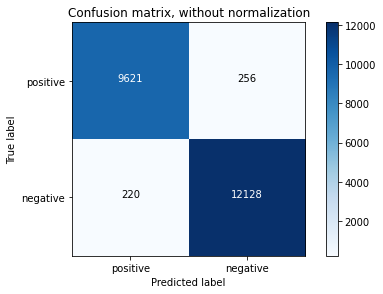

In [ ]:
plot_confusion_matrix(confusion_matrix(preds_thres, y_true), ('positive', 'negative'))

### 5.6.2 - Pipeline for Custom Sentence

In order to get a fast intuiton about the application, let's define a pipeline to process and classify a custom sentence.

In [ ]:
def bert_classification(model, sequence):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Load batch to device
    b_input_ids, b_attn_mask = (sequence['input_ids'].to(device), 
                                sequence['attention_mask'].to(device))

    # Compute logits
    with torch.no_grad():
        logits = model(b_input_ids, b_attn_mask)

    # Apply softmax to calculate probabilities
    probs = F.softmax(logits, dim=1).cpu().numpy()

    return probs

In [ ]:
#@title { vertical-output: true }

#@markdown Insert here a sentence in English
sentence = "After all this process, we can claim this model is super" #@param {type:"string"}

# Preprocess sentence
encoded_sentence = dict()
encoded_sentence['input_ids'], encoded_sentence['attention_mask'] = preprocessing_for_sa(pd.Series(sentence), tokenizer, len(tokenizer.encode(sentence)))

# Compute probabilities
final_probs = bert_classification(bert_classifier, encoded_sentence)

# Print results
print(f"{'Sentiment':^11} | {'Probability':^13}")
print(27*'-')
print(f"{'Positive':^11} | {final_probs[0][1]:^13.5f}")
print(27*'-')
print(f"{'Negative':^11} | {final_probs[0][0]:^13.5f}")
print(27*'-')

 Sentiment  |  Probability 
---------------------------
 Positive   |    0.98319   
---------------------------
 Negative   |    0.01681   
---------------------------


Finally, to download the whole folder.

In [ ]:
def download_folder(dir): 
    !zip -r $dir\.zip $dir
    files.download(f'{dir}.zip')

In [ ]:
#download_folder(sentiment_dir)

# 6 - Question Answering

A more challenged task is **Question Answering**, which corresponds to extract the answer to a question from a given context. In this case the model answers the question by taking a substring of a context, not by generating new text.

We are going to use [SQuAD](https://rajpurkar.github.io/SQuAD-explorer/) (Stanford Question Answering Dataset), a collection of 100k crowdsourced question/answer pairs. Given a question and a passage from Wikipedia containing the answer, the task is to predict the answer text span in the passage. This corresponds with SQuAD 1.1. In SQuAD 2.0 the problem definition is extended allowing for the possibility
that no short answer exists in the provided paragraph, making the problem more realistic.


![Q&A](https://raw.githubusercontent.com/ion-bueno/bert-from-inside/main/images/question_answering.png)

> Image from [Hugging Face models](https://huggingface.co/models)

> For this task it is followed Hugging Face notebook's [question_answering](https://github.com/huggingface/notebooks/blob/master/examples/question_answering.ipynb)

## 6.1 - Setup

As before, the option to change the runtime type to a GPU is a good option.

In [ ]:
# If there's a GPU available...
if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")


There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


## 6.2 - Load SQuAD Dataset

We are going to use [Hugging Face Datasets](https://huggingface.co/docs/datasets/v1.4.1/index.html), so running next cell we install the libraries in Colab.

In [ ]:
!pip install datasets

     |████████████████████████████████| 235kB 2.9MB/s 
     |████████████████████████████████| 112kB 12.4MB/s 
     |████████████████████████████████| 245kB 11.8MB/s 


With method [`load_dataset`](https://huggingface.co/docs/datasets/v1.4.1/package_reference/loading_methods.html#datasets.load_dataset) and specifying the name of the datasets we can load the required data.

In [ ]:
from datasets import load_dataset

# This flag is the difference between SQUAD v1 or 2 
# if you're using another dataset, it indicates if impossible answers are allowed or not).
squad_v2 = False
original_datasets = load_dataset('squad_v2' if squad_v2 else 'squad')

Reusing dataset squad (/root/.cache/huggingface/datasets/squad/plain_text/1.0.0/4fffa6cf76083860f85fa83486ec3028e7e32c342c218ff2a620fc6b2868483a)


The loaded dataset is an object of [`DatasetDict`](https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasetdict). It is a dictionary which contains train and validation samples, with the correspondig `context`, `question` and `answers`. As in the previous task, SQuAD is also used in competitions. In this case, there are not original test data. For this reason, as before, one third of training set is going to be used as test.

In [ ]:
new_split = original_datasets['train'].train_test_split(test_size=0.33)
original_datasets['train'] = new_split['train']
original_datasets['test'] = new_split['test']

With next function we can show random elements in the dataset.

In [ ]:
from datasets import ClassLabel, Sequence
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
        elif isinstance(typ, Sequence) and isinstance(typ.feature, ClassLabel):
            df[column] = df[column].transform(lambda x: [typ.feature.names[i] for i in x])
    display(HTML(df.to_html()))

For a fast intuition on the model, we can remove some data, since the original size of the dataset has more than 80k samples only in training. With `perc` we select the percentage of data we are going to use. Removed sample are selected randomly.

In [ ]:
#@markdown Select a split
split = "train" #@param ["train", "validation", "test"]
#@markdown Select number of examples to visualize it
num_examples = 3 #@param {type:"slider", min:1, max:10, step:1}
print(f'Some sentences of {split} split, which has a length of {original_datasets[split].num_rows}\n')
show_random_elements(original_datasets[split], num_examples)


Some sentences of train split, which has a length of 58691



,answers,context,id,question,title
0,"{'answer_start': [41], 'text': ['Dell 2.0']}","Dell announced a change campaign called ""Dell 2.0,"" reducing the number of employees and diversifying the company's products. While chairman of the board after relinquishing his CEO position, Michael Dell still had significant input in the company during Rollins' years as CEO. With the return of Michael Dell as CEO, the company saw immediate changes in operations, the exodus of many senior vice-presidents and new personnel brought in from outside the company. Michael Dell announced a number of initiatives and plans (part of the ""Dell 2.0"" initiative) to improve the company's financial performance. These include elimination of 2006 bonuses for employees with some discretionary awards, reduction in the number of managers reporting directly to Michael Dell from 20 to 12, and reduction of ""bureaucracy"". Jim Schneider retired as CFO and was replaced by Donald Carty, as the company came under an SEC probe for its accounting practices.",570fd59c5ab6b8190039105d,What was the name of Dell's change campaign?,Dell
1,"{'answer_start': [381], 'text': ['2004']}","The Times is the originator of the widely used Times Roman typeface, originally developed by Stanley Morison of The Times in collaboration with the Monotype Corporation for its legibility in low-tech printing. In November 2006 The Times began printing headlines in a new font, Times Modern. The Times was printed in broadsheet format for 219 years, but switched to compact size in 2004 in an attempt to appeal more to younger readers and commuters using public transport. The Sunday Times remains a broadsheet.",5705e06c52bb891400689646,In what year did The Times change its broadsheet format to a compact size?,The_Times
2,"{'answer_start': [610], 'text': ['by subtracting 1/3 exposure stop']}","The Weston Cadet (model 852 introduced in 1949), Direct Reading (model 853 introduced 1954) and Master III (models 737 and S141.3 introduced in 1956) were the first in their line of exposure meters to switch and utilize the meanwhile established ASA scale instead. Other models used the original Weston scale up until ca. 1955. The company continued to publish Weston film ratings after 1955, but while their recommended values often differed slightly from the ASA film speeds found on film boxes, these newer Weston values were based on the ASA system and had to be converted for use with older Weston meters by subtracting 1/3 exposure stop as per Weston's recommendation. Vice versa, ""old"" Weston film speed ratings could be converted into ""new"" Westons and the ASA scale by adding the same amount, that is, a film rating of 100 Weston (up to 1955) corresponded with 125 ASA (as per ASA PH2.5-1954 and before). This conversion was not necessary on Weston meters manufactured and Weston film ratings published since 1956 due to their inherent use of the ASA system; however the changes of the ASA PH2.5-1960 revision may be taken into account when comparing with newer ASA or ISO values.",57264e6f5951b619008f6f71,How were Weston values changed to ASA values?,Film_speed


As before, for a fast intuition on the model, we can remove some data.

In [ ]:
from datasets import DatasetDict

In [ ]:
#@title 6.2.1 Resize dataset { vertical-output: true }
#@markdown Percentage of dataset to use %
perc = 100 #@param {type:"slider", min:1, max:100, step:1}
datasets = DatasetDict()

for key, dataset in original_datasets.shuffle().items():
    if perc != 100:
        datasets[key] = dataset.select(np.arange(0, round(dataset.num_rows*(perc/100)+1)))
        print(f'{key:<10}\t', f'From: {original_datasets[key].num_rows:<10}', f'To: {datasets[key].num_rows:<10}')
    else:
        datasets[key] = original_datasets[key]
        print(f'{key:<10}\t', f'size: {len(original_datasets[key]):<10}')

train     	 size: 58691     
validation	 size: 10570     
test      	 size: 28908     


## 6.3 - Preprocessing data

In this task the structure of the input differs from sentiment analysis. Now we have two sentences:

\begin{matrix}
    [CLS] & \text{Sentence A} & [SEP] & \text{Sentence B}
\end{matrix}

In this case we are going to use [`BertTokenizerFast`](https://huggingface.co/transformers/model_doc/bert.html#transformers.BertTokenizerFast). This one is a [Fast Tokenizer](https://huggingface.co/transformers/main_classes/tokenizer.html#tokenizer), which according to Hugging Face implies 

- A significant speed-up in particular when doing batched tokenization.
- Additional methods to map between the original string (character and words) and the token space.

As before, we choose [`bert-base-uncased`](https://huggingface.co/bert-base-uncased) as pre-trained model.

In [ ]:
from transformers import BertTokenizerFast

MODEL_NAME = 'bert-base-uncased'

# Load the BERT tokenizer.
print('Loading BERT tokenizer...\n')
tokenizer = BertTokenizerFast.from_pretrained(MODEL_NAME)

Loading BERT tokenizer...



As before, we can check its attributes.

In [ ]:
#@markdown Select an option to visualize it
attribute = "vocab_size" #@param ["vocab_size", "model_max_length", "padding_side", "sep_token", "pad_token", "cls_token", "mask_token", "unk_token"]

print(getattr(tokenizer, attribute))

30522


One problem is how manage long documents. The 
usual truncation process could carry in losing the answer we are looking for. To deal with it, we truncate the context into features, text shorter than maximum length allowed, and allow some overlap between them in case the answer lies at the point we split a long context


In [ ]:
max_length = 384 # The maximum length of a feature (question and context)
doc_stride = 128 # The authorized overlap between two parts of the context when splitting it is needed.

Let's find an example whose length is longer than `max_length`.

In [ ]:
for i, example in enumerate(datasets["train"]):
    if len(tokenizer(example["question"], example["context"])["input_ids"]) > max_length:
        break
example = datasets["train"][i]
example

{'answers': {'answer_start': [593], 'text': ['Charles Horace Mayo']},
 'context': 'The Feinberg School of Medicine (previously the Northwestern University Medical School) has produced a number of notable graduates, including Mary Harris Thompson, Class of 1870, ad eundem, first female surgeon in Chicago, first female surgeon at Cook County Hospital, and founder of the Mary Thomson Hospital, Roswell Park, Class of 1876, prominent surgeon for whom the Roswell Park Cancer Institute in Buffalo, New York, is named, Daniel Hale Williams, Class of 1883, performed the first successful American open heart surgery; only black charter member of the American College of Surgeons, Charles Horace Mayo, Class of 1888, co-founder of Mayo Clinic, Carlos Montezuma, Class of 1889, one of the first Native Americans to receive a Doctor of Medicine degree from any school, and founder of the Society of American Indians, Howard T. Ricketts, Class of 1897, who discovered bacteria of the genus Rickettsia, and id

In [ ]:
print(f'Original length \t{len(tokenizer(example["question"], example["context"])["input_ids"])}')
print(f'Truncated length \t{len(tokenizer(example["question"], example["context"], max_length=max_length, truncation="only_second")["input_ids"])}')

Original length 	419
Truncated length 	384


Only the context should be truncated, specifying `truncation=only_second`. The tokenizer will return a lisf of features capped by a certain maximum length, with the overlap we talked above. We just have to declare `return_overflowing_tokens=True` and `stride=doc_stride` to pass the stride.

Mention we need to find in which of those features the answer actually is, and where exactly in that feature, the start and end positions. The tokenizer we're using can help us with that by returning an `offset_mapping`:

In [ ]:
tokenized_example = tokenizer(
    example["question"],
    example["context"],
    max_length=max_length,
    truncation="only_second",
    return_overflowing_tokens=True,
    return_offsets_mapping=True,
    stride=doc_stride
)

We can plot each of the features in order to see the overlapping part:

In [ ]:
for i, x in enumerate(tokenized_example["input_ids"]):
    print(f'Feature {i+1} with {len(x)} tokens')
    print(tokenizer.convert_ids_to_tokens(x), '\n') # or tokenizer.decode(x)

Feature 1 with 384 tokens
['[CLS]', 'which', 'graduate', 'of', 'the', 'fein', '##burg', 'school', 'of', 'medicine', 'co', '-', 'founded', 'the', 'mayo', 'clinic', '?', '[SEP]', 'the', 'fein', '##berg', 'school', 'of', 'medicine', '(', 'previously', 'the', 'northwestern', 'university', 'medical', 'school', ')', 'has', 'produced', 'a', 'number', 'of', 'notable', 'graduates', ',', 'including', 'mary', 'harris', 'thompson', ',', 'class', 'of', '1870', ',', 'ad', 'eun', '##de', '##m', ',', 'first', 'female', 'surgeon', 'in', 'chicago', ',', 'first', 'female', 'surgeon', 'at', 'cook', 'county', 'hospital', ',', 'and', 'founder', 'of', 'the', 'mary', 'thomson', 'hospital', ',', 'ro', '##swell', 'park', ',', 'class', 'of', '1876', ',', 'prominent', 'surgeon', 'for', 'whom', 'the', 'ro', '##swell', 'park', 'cancer', 'institute', 'in', 'buffalo', ',', 'new', 'york', ',', 'is', 'named', ',', 'daniel', 'hale', 'williams', ',', 'class', 'of', '1883', ',', 'performed', 'the', 'first', 'successful', 

And how the tokenizer can provide us the positions of each token:

In [ ]:
rnd_index = random.randint(0, len(tokenized_example["input_ids"][0])-1)
token_id = tokenized_example["input_ids"][0][rnd_index]
offsets = tokenized_example["offset_mapping"][0][rnd_index]

print(f'Token {rnd_index} \t{tokenizer.convert_ids_to_tokens(token_id)}\n')

print(f'Start position \t{offsets[0]}')
print(f'End position \t{offsets[1]}')

Token 74 	libyan

Start position 	271
End position 	277


To distinguish which parts of the offsets correspond to the question and which part correspond to the context, we can use [`sequence_ids`](https://huggingface.co/transformers/main_classes/tokenizer.html#transformers.BatchEncoding.sequence_ids) method. It returns `None` for the special tokens, then 0 or 1 depending on whether the corresponding token comes from the first sentence past (the question) or the second (the context).

In [ ]:
sequence_ids = tokenized_example.sequence_ids()
print(sequence_ids)

[None, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, None, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

With all of this, the last step is to check if the answer is in the feature or in the next one.

In [ ]:
answers = example["answers"]
start_char = answers["answer_start"][0]
end_char = start_char + len(answers["text"][0])

# Start token index of the current span in the text.
token_start_index = 0
while sequence_ids[token_start_index] != 1:
    token_start_index += 1

# End token index of the current span in the text.
token_end_index = len(tokenized_example["input_ids"][0]) - 1
while sequence_ids[token_end_index] != 1:
    token_end_index -= 1

# Detect if the answer is out of the span (in which case this feature is labeled with the CLS index).
offsets = tokenized_example["offset_mapping"][0]
if (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char):
    # Move the token_start_index and token_end_index to the two ends of the answer.
    # Note: we could go after the last offset if the answer is the last word (edge case).
    while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
        token_start_index += 1
    start_position = token_start_index - 1
    while offsets[token_end_index][1] >= end_char:
        token_end_index -= 1
    end_position = token_end_index + 1
    print(f'Original answer \t{answers["text"][0]}', '\n')
    print(f'Start position \t\t{start_position}')
    print(f'End position \t\t{end_position}')
    print(f'In feature \t\t{tokenizer.decode(tokenized_example["input_ids"][0][start_position: end_position+1])}')
else:
    print("The answer is not in this feature.")

Original answer 	€50 million 

Start position 		245
End position 		247
In feature 		€50 million


Once all steps are explained, we can integrate them in a whole function to preprocess whole data.

In [ ]:
def preprocessing_for_qa(examples):
    # Tokenize our examples with truncation and padding, but keep the overflows using a stride. This results
    # in one example possible giving several features when a context is long, each of those features having a
    # context that overlaps a bit the context of the previous feature.
    tokenized_examples = tokenizer(
        examples["question"],               #tokenize question
        examples["context"],                #tokenize context
        truncation="only_second",           #truncate only context if necessary
        max_length=max_length,              #variable max_length
        stride=doc_stride,                  #overlap to stride
        return_overflowing_tokens=True,     #return overflowing tokens
        return_offsets_mapping=True,        #return offsets mapping
        padding="max_length"                #pad to max length
    )

    # Since one example might give us several features if it has a long context, we need a map from a feature to
    # its corresponding example. This key gives us just that.
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")

    # The offset mappings will give us a map from token to character position in the original context. This will
    # help us compute the start_positions and end_positions.
    offset_mapping = tokenized_examples.pop("offset_mapping")

    # Let's label those examples!
    tokenized_examples["start_positions"] = []
    tokenized_examples["end_positions"] = []

    for i, offsets in enumerate(offset_mapping):
        # We will label impossible answers with the index of the CLS token.
        input_ids = tokenized_examples["input_ids"][i]
        cls_index = input_ids.index(tokenizer.cls_token_id)

        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)

        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]
        answers = examples["answers"][sample_index]

        # If no answers are given, set the cls_index as answer.
        if len(answers["answer_start"]) == 0:
            tokenized_examples["start_positions"].append(cls_index)
            tokenized_examples["end_positions"].append(cls_index)
        else:
            # Start/end character index of the answer in the text.
            start_char = answers["answer_start"][0]
            end_char = start_char + len(answers["text"][0])

            # Start token index of the current span in the text.
            token_start_index = 0
            while sequence_ids[token_start_index] != 1:
                token_start_index += 1

            # End token index of the current span in the text.
            token_end_index = len(input_ids) - 1
            while sequence_ids[token_end_index] != 1:
                token_end_index -= 1

            # Detect if the answer is out of the span (in which case this feature is labeled with the CLS index).
            if not (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char):
                tokenized_examples["start_positions"].append(cls_index)
                tokenized_examples["end_positions"].append(cls_index)
            else:
                # Otherwise move the token_start_index and token_end_index to the two ends of the answer.
                # Note: we could go after the last offset if the answer is the last word (edge case).
                while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
                    token_start_index += 1
                tokenized_examples["start_positions"].append(token_start_index - 1)
                while offsets[token_end_index][1] >= end_char:
                    token_end_index -= 1
                tokenized_examples["end_positions"].append(token_end_index + 1)

    return tokenized_examples

Now, we only have to apply the function to the different splits. We can use the [`map`](https://huggingface.co/docs/datasets/v1.4.1/package_reference/main_classes.html?highlight=map#datasets.Dataset.map) method:

In [ ]:
tokenized_datasets = datasets.map(preprocessing_for_qa, 
                                  batched=True, 
                                  remove_columns=datasets["train"].column_names)

The results are automatically cached by the [Datasets](https://huggingface.co/docs/datasets/v1.4.1/index.html) library to avoid spending time on this step the next time you run your notebook. With `load_from_cache_file=False` in the call to [`map`](https://huggingface.co/docs/datasets/v1.4.1/package_reference/main_classes.html?highlight=map#datasets.Dataset.map), the cached files are not used and the preprocessing is applied again.

Note that we passed `batched=True` to encode the texts by batches together. This is to leverage the full benefit of the fast tokenizer we loaded earlier, which will use multi-threading to treat the texts in a batch concurrently.

Once the original datasets are tokenizer, we get another [`DatasetDict`](https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasetdict), but with different columns than the original one: `attention_mask`, used to indicate words from additional padding, `input_ids`, tokens as integers, and `token_type_ids`, indicating to which sentence words belongs. Finally the start and end positions of the answer.

In [ ]:
#@markdown Select a split
split = "train" #@param ["train", "validation", "test"]
#@markdown Select number of examples to visualize it
num_examples = 3 #@param {type:"slider", min:1, max:10, step:1}
print(f'Some sentences of {split} split, which has a length of {tokenized_datasets[split].num_rows}\n')
show_random_elements(tokenized_datasets[split], num_examples)

Some sentences of train split, which has a length of 59315



,attention_mask,end_positions,input_ids,start_positions,token_type_ids
0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...]",92,"[101, 2096, 2002, 2001, 1999, 3905, 2082, 1010, 2054, 4066, 1997, 16841, 2106, 28924, 2490, 1029, 102, 28924, 4114, 13616, 1998, 5500, 14921, 21289, 1996, 12078, 1012, 1999, 2255, 3777, 1010, 2002, 2419, 1037, 10467, 21248, 7795, 1005, 1055, 22965, 2013, 1996, 2142, 5424, 3072, 1012, 2076, 2023, 2027, 3631, 3645, 1997, 1037, 2334, 3309, 5496, 1997, 3529, 6544, 1012, 9105, 1996, 4614, 1005, 3086, 1010, 2027, 10016, 2010, 2155, 2013, 11200, 1012, 28924, 2333, 2000, 28616, 14660, 1010, 2045, 7052, 28616, 14660, 3905, 2082, 1012, 8498, 2010, 3037, 1999, 5424, 8986, 16841, 1010, 2002, 4188, 2000, 3693, 2151, 1997, ...]",90,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...]"
1,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...]",154,"[101, 2129, 2106, 28924, 2903, 1996, 3956, 1011, 8976, 4736, 2323, 2022, 10395, 1029, 102, 1037, 8050, 2112, 1997, 28924, 1005, 1055, 13165, 2001, 3424, 1011, 19999, 2964, 1012, 2002, 3373, 2008, 1996, 2110, 1997, 3956, 2323, 2025, 4839, 1010, 1998, 2008, 2151, 5424, 12014, 2007, 1996, 5611, 2231, 2001, 1037, 14583, 1997, 1996, 5424, 2111, 1012, 1999, 2312, 2112, 2349, 2000, 2037, 2490, 1997, 3956, 1010, 28924, 26626, 1996, 2142, 2163, 1010, 6195, 1996, 2406, 2000, 2022, 4461, 2923, 1998, 12559, 14083, 2075, 2009, 2004, 1000, 1996, 7861, 5092, 21341, 1997, 4763, 1012, 1000, 8320, 2075, 2114, 5181, 1999, ...]",148,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...]"
2,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...]",0,"[101, 1999, 2054, 2095, 2106, 1037, 2413, 2932, 6235, 1996, 2224, 1997, 16295, 1029, 102, 15486, 1999, 2605, 2127, 1996, 4329, 1997, 9500, 1012, 2059, 1010, 1999, 1996, 20400, 1010, 2045, 2001, 1037, 12058, 1997, 3037, 1010, 1998, 16295, 2150, 4235, 2109, 1000, 2005, 14271, 2015, 1010, 4257, 15753, 1010, 1998, 1996, 14834, 1997, 20199, 16451, 2015, 1010, 1998, 1999, 2563, 1010, 2070, 2224, 1997, 2009, 2018, 2042, 2081, 1997, 2009, 2005, 2714, 5682, 1000, 1012, 2049, 4125, 1999, 2885, 2001, 1000, 1037, 5573, 9575, 1000, 1010, 2044, 3019, 10042, 2020, 2179, 1000, 1999, 2605, 2012, 9808, 8193, 2078, 1006, ...]",0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...]"


## 6.4 - Generate the Model

To fine tune on **Question Answering**, it is introduced a start vector $ S \in \mathbb R^{H} $ and an end vector $ E \in \mathbb R^{H} $.

![Fine tune Q&A](https://raw.githubusercontent.com/ion-bueno/bert-from-inside/main/images/question_answering_fine_tune.png)

To compute the probability of a word $ i $ being the start or the end of the answer, we compute the dot product between $ S $ and $ T_i $ followed by a softmax over all the words in the sequence.

\begin{equation}
    P_i = \frac{e^{S \cdot T_i}}{\sum_{j} e^{S \cdot T_j}}
\end{equation} 

The score for a candidate is defined as $ S \cdot T_i \ + \ E \cdot T_j $, where $ i $ is the start position and $ j $ the final position. The maximum scoring span: $ \hat{s_{i, j}} = max_{j \geq i} S \cdot T_i \ + \ E \cdot T_j $ is used as prediction, where the training objective is the sum of the log-likelihoods of the correct start and end positions.

![Model Q&A](https://raw.githubusercontent.com/ion-bueno/bert-from-inside/main/images/bert-qa.png)

To extend to SQuAD 2.0, questions which do not have an answer have an span with start and end at the $ [CLS] $ token. It is compared the score of the null answer span: $ s_{null} = S \cdot C \ + E \cdot C $ with $ \hat{s_{i, j}} $. It is predicted a non-null answer if $ \hat{s_{i, j}} > s_{null} \ + \ \tau$, where threshold $ \tau $ i selected on the validation set to maximize F1.

In this task we are going to use the model designed by Hugging Face [`BertForQuestionAnswering`](https://huggingface.co/transformers/model_doc/bert.html#transformers.BertForQuestionAnswering).

In [ ]:
from transformers import BertForQuestionAnswering

bert_qa = BertForQuestionAnswering.from_pretrained(MODEL_NAME)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForQuestionAnswering: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased a

In [ ]:
#@markdown Select whole model, only pretrained BERT or the question & answer outputs
block = "model" #@param ["model", "bert", "qa_outputs"]
if block == 'model':
    print(bert_qa)
else:
    print(getattr(model, block))

BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

## 6.5 - Fine-Tune on SQuAD

Now it is the moment to train the model for our specific task. We can use an instance of [`Trainer`](https://huggingface.co/transformers/main_classes/trainer.html?highlight=trainer#transformers.Trainer) class in order to avoid many lines of code. The most important is the [`TrainingArguments`](https://huggingface.co/transformers/main_classes/trainer.html#transformers.TrainingArguments), which is a class that contains all the attributes to customize the training. It requires one folder name, which will be used to save the checkpoints of the model, and all other arguments are optional.

In [ ]:
from transformers import TrainingArguments

In [ ]:
#@title 6.5.1 - Hyperparameters Selection
batch_size =  16#@param {type:"integer"}
learning_rate = 5e-5 #@param {type:"number"}
epochs =  3#@param {type:"integer"}
epsilon = 1e-8 #@param {type:"number"}
weight_decay=0.01 #@param {type:"number"}
qa_dir = Path('question_answering')
strategy = 'epoch'

args = TrainingArguments(
    qa_dir,
    evaluation_strategy = strategy,
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epochs,
    weight_decay=weight_decay,
    logging_dir= 'squad_logs',
    logging_strategy=strategy,
    load_best_model_at_end=True
)

For example, in this case we set the evaluation to be done at the end of each epoch in `evaluation_strategy`. Customize batch size per GPU core for training `per_device_train_batch_size` and evaluation `per_device_eval_batch_size`. In addition to give values for the total number of epochs to perform `num_train_epohs`, `learning_rate` and `weight_decay`.

Then it is only needed to pass the arguments and dataset to [`Trainer`](https://huggingface.co/transformers/main_classes/trainer.html?highlight=trainer#transformers.Trainer). The data collator will batch our processed examples together. The tokenizer is used again in order to perfom padding according to the model's preferences: rigth or left and with which token.

In [ ]:
from transformers import Trainer, default_data_collator

In [ ]:
trainer = Trainer(
    bert_qa,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=default_data_collator,
    tokenizer=tokenizer
)

In order to fine-tune the model it is only required to call the [`train`](https://huggingface.co/transformers/main_classes/trainer.html?highlight=trainer#transformers.Trainer.train) method for [`Trainer`](https://huggingface.co/transformers/main_classes/trainer.html?highlight=trainer#transformers.Trainer).

In [ ]:
info_device()    
out = trainer.train()


Using GPU Tesla V100-SXM2-16GB. 



Epoch,Training Loss,Validation Loss
1,1.329400,1.086206
2,0.718000,1.077027
3,0.408300,1.287688


Now it is necesary to perform some operation to get the final results. We need to load the saved checkpoint and extract the information. Mention Hugging Face does not provide the training time per epoch, only total one. Due to that, we assume an equal distribution of time in each epoch.

In [ ]:
checkpoint = qa_dir/f'checkpoint-{out.global_step}/trainer_state.json'

with open(checkpoint) as json_file:
    train_dic = json.load(json_file)

total_train_time = out.metrics['train_runtime']
training_stats = []
for i in range(epochs):
    training_stats.append(
                {
                    'epoch': i + 1,
                    'Training Loss': train_dic['log_history'][i*2]['loss'],
                    'Validation Loss': train_dic['log_history'][i*2+1]['eval_loss'],
                    'Validation Time':  format_time(train_dic['log_history'][i*2+1]['eval_runtime'])
                }
    )

In [ ]:
# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)
df_stats['Training Time'] = format_time(total_train_time/epochs)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')
df_stats = df_stats[['Training Loss', 'Validation Loss', 'Training Time', 'Validation Time']]

# Save data frame
df_stats.to_excel(qa_dir/'training_stats.xlsx')

df_stats

,Training Loss,Validation Loss,Training Time,Validation Time
epoch,,,,
1,1.3294,1.086206,0:27:47,0:01:16
2,0.7180,1.077027,0:27:47,0:01:16
3,0.4083,1.287688,0:27:47,0:01:16


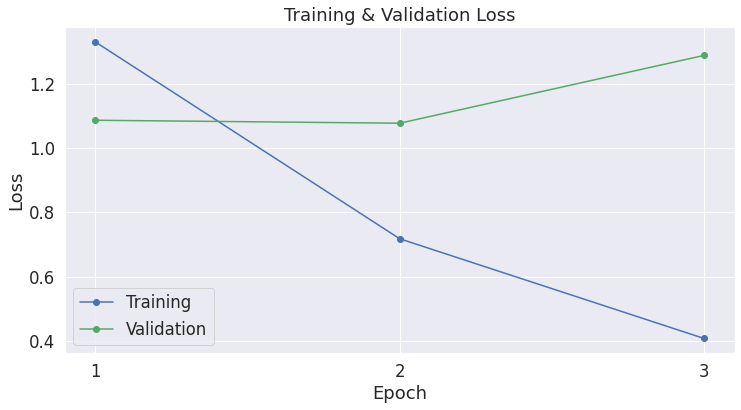

In [ ]:
plot_loss_curves(df_stats)

Save the model and the corresponding state.

In [ ]:
print('Saving model, tokenizer and training arguments...')
trainer.save_model()
trainer.save_state()

print('Saving training statistics..')
save_json(qa_dir/'training_stats.json', training_stats)

Saving model and training arguments...
Saving training statistics..


And if we want to load it again.

In [ ]:
bert_qa = BertForQuestionAnswering.from_pretrained(qa_dir)
bert_qa.to(device)
trainer = Trainer(
    bert_qa,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=default_data_collator,
    tokenizer=tokenizer
)

## 6.6 - Evaluation

Once the model is trained, in order to perform the predictions and get an intuition about the result, we need to map the predictions back to parts of the context. The model itself predicts logits for the start and end position of our answers. The output of the model is a dict-like object that contains the loss (since we provided labels), the start and end logits. 

In [ ]:
for batch in trainer.get_test_dataloader(tokenized_datasets['test']):
    break
batch = {k: v.to(trainer.args.device) for k, v in batch.items()}
with torch.no_grad():
    output = bert_qa(**batch)

print('Output of the model')
print(output.keys())
print('\nDimension start and end logits')
print(tuple(output.start_logits.shape))

Output of the model
odict_keys(['loss', 'start_logits', 'end_logits'])

Dimension start and end logits
(16, 384)


There is one logit per feature and token. One idea to predict an answer is to take the index for the maximum of the start logits as a star position and the index of the maximum of the ends logits as an end position. The problem is if this prediction gives us an impossible result, as a greater start position than the end one.

To classify the answer, we add the start and end logits to obtain a score. With hyper-parameter `n_best_size` we limit the possible answers. Best indices in the start and end logits are picked and gather all the answers this predicts. After checking if each one is valid, we will sort them by their score and keep the best one.

And then we can sort the `valid_answers` according to their `score` and only keep the best one. The only point left is how to check a given span is inside the context (and not the question) and how to get back the text inside. To do this, we need to add two things to our validation features:
- the ID of the example that generated the feature (since each example can generate several features, as seen before);
- the offset mapping that will give us a map from token indices to character positions in the context.

That's why we will re-process the validation set with the following function.

In [ ]:
def prepare_test_features(examples):
    # Tokenize our examples with truncation and maybe padding, but keep the overflows using a stride. This results
    # in one example possible giving several features when a context is long, each of those features having a
    # context that overlaps a bit the context of the previous feature.
    tokenized_examples = tokenizer(
        examples["question"],
        examples["context"],
        truncation="only_second",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length"
    )

    # Since one example might give us several features if it has a long context, we need a map from a feature to
    # its corresponding example. This key gives us just that.
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")

    # We keep the example_id that gave us this feature and we will store the offset mappings.
    tokenized_examples["example_id"] = []

    for i in range(len(tokenized_examples["input_ids"])):
        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)

        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]
        tokenized_examples["example_id"].append(examples["id"][sample_index])

        # Set to None the offset_mapping that are not part of the context so it's easy to determine if a token
        # position is part of the context or not.
        tokenized_examples["offset_mapping"][i] = [
            (o if sequence_ids[k] == 1 else None)
            for k, o in enumerate(tokenized_examples["offset_mapping"][i])
        ]

    return tokenized_examples

And like before, we can apply that function to our test set easily.

In [ ]:
test_features = datasets['test'].map(
    prepare_test_features,
    batched=True,
    remove_columns=datasets['test'].column_names
)
test_features = test_features.add_column('start_positions', tokenized_datasets['test']['start_positions'])
test_features = test_features.add_column('end_positions', tokenized_datasets['test']['end_positions'])

Now we can get the predictions and the metrics for all features by using the [`predict`](https://huggingface.co/transformers/main_classes/trainer.html?highlight=trainer%20predict#transformers.Trainer.predict).

In [ ]:
info_device()
print('Testing\n')
raw_predictions = trainer.predict(test_features)

test_stats = {
    'test_loss': raw_predictions.metrics['test_loss'],
    'test_runtime': format_time(raw_predictions.metrics['test_runtime'])
}

print('\n')
print(f"{'Test Loss':^12} | {'Test time':^11}")
print("-"*27)
print(f"{test_stats['test_loss']:^12.6f} | {test_stats['test_runtime']:^11}")
print("-"*27)


Using GPU Tesla V100-SXM2-16GB. 

Testing





 Test Loss   |  Test time 
---------------------------
  1.022919   |   0:03:49  
---------------------------


In [ ]:
print('Saving test statistics...')
save_json(qa_dir/'test_stats.json', test_stats)

Saving test statistics...


The `Trainer` *hides* the columns that are not used by the model (here `example_id` and `offset_mapping` which we will need for our post-processing), so we set them back:

In [ ]:
test_features.set_format(type=test_features.format["type"], columns=list(test_features.features.keys()))

We set `None` in the offset mappings when it corresponds to a part of the question, so it's easy to check if an answer is fully inside the context. We also eliminate very long answers from our considerations with hyper-parameter `max_answer_length`.

We also need a map between examples and their corresponding features. Also, we gather together all the answers in all the features generated by a given example, then pick the best one.

The last bit to deal with is the impossible answer (when `squad_v2 = True`). We need to also grab the score for the impossible answer (which has start and end indices corresponding to the index of the CLS token). When one example gives several features, we have to predict the impossible answer when all the features give a high score to the impossible answer, since one feature could predict the impossible answer just because the answer isn't in the part of the context it has access too. We then predict the impossible answer when that score is greater than the score of the best non-impossible answer. 

In [ ]:
import collections
from tqdm.auto import tqdm

def postprocess_predictions(examples, features, raw_predictions, n_best_size = 20, max_answer_length = 30):
    m = nn.Softmax(dim=1)
    all_start_logits, all_end_logits = raw_predictions
    # Build a map example to its corresponding features.
    example_id_to_index = {k: i for i, k in enumerate(examples["id"])}
    features_per_example = collections.defaultdict(list)
    for i, feature in enumerate(features):
        features_per_example[example_id_to_index[feature["example_id"]]].append(i)

    # The dictionaries we have to fill.
    predictions = collections.OrderedDict()

    # Logging.
    print(f"Post-processing {len(examples)} example predictions split into {len(features)} features.")

    # Let's loop over all the examples!
    for example_index, example in enumerate(tqdm(examples)):
        # Those are the indices of the features associated to the current example.
        feature_indices = features_per_example[example_index]

        min_null_score = None # Only used if squad_v2 is True.
        valid_answers = []
        
        context = example["context"]
        # Looping through all the features associated to the current example.
        for feature_index in feature_indices:
            # We grab the predictions of the model for this feature.
            start_logits = all_start_logits[feature_index]
            end_logits = all_end_logits[feature_index]
            # This is what will allow us to map some the positions in our logits to span of texts in the original
            # context.
            offset_mapping = features[feature_index]["offset_mapping"]

            # Update minimum null prediction.
            cls_index = features[feature_index]["input_ids"].index(tokenizer.cls_token_id)
            feature_null_score = start_logits[cls_index] + end_logits[cls_index]
            if min_null_score is None or min_null_score < feature_null_score:
                min_null_score = feature_null_score

            # Go through all possibilities for the `n_best_size` greater start and end logits.
            start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
            end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # Don't consider out-of-scope answers, either because the indices are out of bounds or correspond
                    # to part of the input_ids that are not in the context.
                    if (
                        start_index >= len(offset_mapping)
                        or end_index >= len(offset_mapping)
                        or offset_mapping[start_index] is None
                        or offset_mapping[end_index] is None
                    ):
                        continue
                    # Don't consider answers with a length that is either < 0 or > max_answer_length.
                    if end_index < start_index or end_index - start_index + 1 > max_answer_length:
                        continue

                    start_char = offset_mapping[start_index][0]
                    end_char = offset_mapping[end_index][1]
                    valid_answers.append(
                        {
                            "score": start_logits[start_index] + end_logits[end_index],
                            "text": context[start_char: end_char]
                        }
                    )
        
        if len(valid_answers) > 0:
            best_answer = sorted(valid_answers, key=lambda x: x["score"], reverse=True)[0]
        else:
            # In the very rare edge case we have not a single non-null prediction, we create a fake prediction to avoid
            # failure.
            best_answer = {"text": "", "score": 0.0}

        # Let's pick our final answer: the best one or the null answer (only for squad_v2)
        if not squad_v2:
            predictions[example["id"]] = best_answer["text"]
        else:
            predictions[example["id"]] = best_answer["text"] if best_answer["score"] > min_null_score else ''

    return predictions

And we can apply our post-processing function to our raw predictions:

In [ ]:
final_predictions = postprocess_predictions(datasets['test'], test_features, raw_predictions.predictions)

Post-processing 28908 example predictions split into 29209 features.


Now it is necessary to indicate how to compute metrics from the predictions. We use a [`metric`](https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasets.Metric) which is in charge of compute the corresponding metrics for each model. We load it using the class method [`load_metric`](https://huggingface.co/docs/datasets/v1.4.1/package_reference/loading_methods.html?highlight=load_metric#datasets.load_metric).

In [ ]:
from datasets import load_metric

metric = load_metric("squad_v2" if squad_v2 else "squad")
metric

Metric(name: "squad", features: {'predictions': {'id': Value(dtype='string', id=None), 'prediction_text': Value(dtype='string', id=None)}, 'references': {'id': Value(dtype='string', id=None), 'answers': Sequence(feature={'text': Value(dtype='string', id=None), 'answer_start': Value(dtype='int32', id=None)}, length=-1, id=None)}}, usage: """
Computes SQuAD scores (F1 and EM).
Args:
    predictions: List of question-answers dictionaries with the following key-values:
        - 'id': id of the question-answer pair as given in the references (see below)
        - 'prediction_text': the text of the answer
    references: List of question-answers dictionaries with the following key-values:
        - 'id': id of the question-answer pair (see above),
        - 'answers': a Dict in the SQuAD dataset format
            {
                'text': list of possible texts for the answer, as a list of strings
                'answer_start': list of start positions for the answer, as a list of ints
   

We just need to format predictions and labels a bit as it expects a list of dictionaries and not one big dictionary. In the case of squad_v2, we also have to set a `no_answer_probability` argument which we set to 0.0.

Metrics computation returns:
    
- `exact_match`: exact match (the normalized answer exactly match the gold answer).

- `f1`: the F-score of predicted tokens versus the gold answer.

In [ ]:
if squad_v2:
    formatted_predictions = [{"id": k, "prediction_text": v, "no_answer_probability": 0.0} for k, v in final_predictions.items()]
else:
    formatted_predictions = [{"id": k, "prediction_text": v} for k, v in final_predictions.items()]
references = [{"id": ex["id"], "answers": ex["answers"]} for ex in datasets['test']]
scores = metric.compute(predictions=formatted_predictions, references=references)

print(f"{'Exact match':^13} | {'f1 score':^10}")
print(26*'-')
print(f"{scores['exact_match']:^13.5f} | {scores['f1']:^10.5f}")
print(26*'-')

 Exact match  |  f1 score 
--------------------------
  67.40349    |  80.89019 
--------------------------


In [ ]:
def show_predictions(dataset, predictions, num_examples):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    df = pd.DataFrame(dataset[picks])
    df.drop(['id', 'title'], axis=1, inplace=True)
    df['answers'] = df['answers'].map(lambda dic: dic['text'][0]).values
    df['predicted answers'] = [predictions[idx]['prediction_text'] for idx in picks]
    df = df[['context', 'question', 'answers', 'predicted answers']]
    for column, typ in dataset.features.items():
        if isinstance(typ, ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
        elif isinstance(typ, Sequence) and isinstance(typ.feature, ClassLabel):
            df[column] = df[column].transform(lambda x: [typ.feature.names[i] for i in x])
    display(HTML(df.to_html()))

In [ ]:
#@markdown Select number of examples to visualize it
num_examples = 3 #@param {type:"slider", min:1, max:5, step:1}
show_predictions(datasets['test'], formatted_predictions, num_examples)

,context,question,answers,predicted answers
0,"The city also has a number of other, smaller newspapers and magazine in circulation such as the Philadelphia Tribune, which serves the African-American community, the Philadelphia, a monthly regional magazine; Philadelphia Weekly, an weekly-printed alternative newspaper; Philadelphia City Paper another weekly-printed newspaper; Philadelphia Gay News, which services the LGBT community; The Jewish Exponent a weekly-printed newspaper servicing the Jewish community; Philadelphia Metro, free daily newspaper; and Al Día, a weekly newspaper servicing the Latino community.",Name a smaller newspaper?,Philadelphia Tribune,all current commercial and laboratory lines are considered to have originated from this population.
1,"Boston was an early port of the Atlantic triangular slave trade in the New England colonies, but was soon overtaken by Salem, Massachusetts and Newport, Rhode Island. Eventually Boston became a center of the abolitionist movement. The city reacted strongly to the Fugitive Slave Law of 1850, contributing to President Franklin Pierce's attempt to make an example of Boston after the Anthony Burns Fugitive Slave Case.",What movement did Boston become the center of after it stopped slave trade?,the abolitionist movement,December 2007
2,"Von Braun and his team were sent to the United States Army's White Sands Proving Ground, located in New Mexico, in 1945. They set about assembling the captured V2s and began a program of launching them and instructing American engineers in their operation. These tests led to the first rocket to take photos from outer space, and the first two-stage rocket, the WAC Corporal-V2 combination, in 1949. The German rocket team was moved from Fort Bliss to the Army's new Redstone Arsenal, located in Huntsville, Alabama, in 1950. From here, von Braun and his team would develop the Army's first operational medium-range ballistic missile, the Redstone rocket, that would, in slightly modified versions, launch both America's first satellite, and the first piloted Mercury space missions. It became the basis for both the Jupiter and Saturn family of rockets.",Von Braun and his associates were sent to United States Army's White Sands Proving Ground in what year?,1945,one or both parents


### 6.6.1 - Pipeline for Custom Sentence

In order to get a fast intuiton about the application, let's define a pipeline to process and try to answer to a question from our own text.

In [ ]:
from datasets import Dataset

def bert_for_qa(context, question, trainer, id='0'):
    # Generate dataset from input data
    dataset = Dataset.from_dict(
        {'id': [id], 'context': [context], 'question': [question]}
    )
    # Preprocess data
    features = dataset.map(
        prepare_test_features,
        batched=True,
        remove_columns=dataset.column_names
    )
    # Predictions
    predictions = trainer.predict(features)
    # Postprocess data
    processed_predictions = postprocess_predictions(dataset, features, predictions.predictions)
    # Return answer
    return processed_predictions[id]

In [ ]:
#@title { vertical-output: true }
context = "BERT is the best model for NLP, so much better than RNNs... I love it!" #@param {type:"string"}
question = "Which model do I love?" #@param {type:"string"}
answer = bert_for_qa(context, question, trainer)

print('\nThe predicted answer is\n')
print(answer)


Post-processing 1 example predictions split into 1 features.




The predicted answer is

BERT


To donwload it.

In [ ]:
download_folder(qa_dir)